In [1]:
# import
import os
import pandas as pd
import plotly.express as px
import scipy.io as sio
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import torch.nn as nn
# from torchinfo import summary
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss,ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import time

# **EDA**

## Reading Data into Dataframes

> The data stored in .dat files with no headers for the columns, we used the readme file to create the columns names for better visualization in our data

In [ ]:
names=["timestamp(s)", "activityID", "heart rate (bpm)",
      "IMU hand temperature","IMU hand acceleration 1 16g",
      "IMU hand acceleration 2 16g","IMU hand acceleration 3 16g",
      "IMU hand acceleration 1 6g","IMU hand acceleration 2 6g",
      "IMU hand acceleration 3 6g","IMU hand gyroscope 1",
      "IMU hand gyroscope 2","IMU hand gyroscope 3",
      "IMU hand magnetometer 1","IMU hand magnetometer 2",
      "IMU hand magnetometer 3","IMU hand orientation(invalid) 1",
      "IMU hand orientation(invalid) 2","IMU hand orientation(invalid) 3",
      "IMU hand orientation(invalid) 4",
      "IMU chest temperature","IMU chest acceleration 1 16g",
      "IMU chest acceleration 2 16g","IMU chest acceleration 3 16g",
      "IMU chest acceleration 1 6g","IMU chest acceleration 2 6g",
      "IMU chest acceleration 3 6g","IMU chest gyroscope 1",
      "IMU chest gyroscope 2","IMU chest gyroscope 3",
      "IMU chest magnetometer 1","IMU chest magnetometer 2",
      "IMU chest magnetometer 3","IMU chest orientation(invalid) 1",
      "IMU chest orientation(invalid) 2","IMU chest orientation(invalid) 3",
      "IMU chest orientation(invalid) 4",
      "IMU ankle temperature","IMU ankle acceleration 1 16g",
      "IMU ankle acceleration 2 16g","IMU ankle acceleration 3 16g",
      "IMU ankle acceleration 1 6g","IMU ankle acceleration 2 6g",
      "IMU ankle acceleration 3 6g","IMU ankle gyroscope 1",
      "IMU ankle gyroscope 2","IMU ankle gyroscope 3",
      "IMU ankle magnetometer 1","IMU ankle magnetometer 2",
      "IMU ankle magnetometer 3","IMU ankle orientation(invalid) 1",
      "IMU ankle orientation(invalid) 2","IMU ankle orientation(invalid) 3",
      "IMU ankle orientation(invalid) 4"]

Read data files to dataframes

> Note: we also included the optional data files that extended the activities of subjects: 101, 105, 106, 108, 109.
Insertion was performed at the end of the timestamp of the original file using a new continous timestamp for the optional data.


In [ ]:
dataframe101 = pd.read_csv('./data/Protocol/subject101.dat', sep='\s',header=None)
dataframe102 = pd.read_csv('./data/Protocol/subject102.dat', sep='\s',header=None)
dataframe103 = pd.read_csv('./data/Protocol/subject103.dat', sep='\s',header=None)
dataframe104 = pd.read_csv('./data/Protocol/subject104.dat', sep='\s',header=None)
dataframe105 = pd.read_csv('./data/Protocol/subject105.dat', sep='\s',header=None)
dataframe106 = pd.read_csv('./data/Protocol/subject106.dat', sep='\s',header=None)
dataframe107 = pd.read_csv('./data/Protocol/subject107.dat', sep='\s',header=None)
dataframe108 = pd.read_csv('./data/Protocol/subject108.dat', sep='\s',header=None)
dataframe109 = pd.read_csv('./data/Protocol/subject109.dat', sep='\s',header=None)
dataframe101_optional = pd.read_csv('./data/Optional/subject101_optional.dat', sep='\s',header=None)
dataframe105_optional = pd.read_csv('./data/Optional/subject105_optional.dat', sep='\s',header=None)
dataframe106_optional = pd.read_csv('./data/Optional/subject106_optional.dat', sep='\s',header=None)
dataframe108_optional = pd.read_csv('./data/Optional/subject108_optional.dat', sep='\s',header=None)
dataframe109_optional = pd.read_csv('./data/Optional/subject109_optional.dat', sep='\s',header=None)     

In [ ]:
def get_new_timestamp_list(df,df_optional):
  last_time = df[0].max()
  l = [last_time + 0.01*i for i in range(1,len(df_optional)+1)]
  df_optional[0] = l
  return df_optional

In [ ]:
to_add_101 = get_new_timestamp_list(dataframe101,dataframe101_optional)
to_add_105 = get_new_timestamp_list(dataframe105,dataframe105_optional)
to_add_106 = get_new_timestamp_list(dataframe106,dataframe106_optional)
to_add_108 = get_new_timestamp_list(dataframe108,dataframe108_optional)
to_add_109 = get_new_timestamp_list(dataframe109,dataframe109_optional)

In [ ]:
dataframe101 = dataframe101.append(to_add_101, ignore_index=True)
dataframe105 = dataframe105.append(to_add_105, ignore_index=True)
dataframe106 = dataframe106.append(to_add_106, ignore_index=True)
dataframe108 = dataframe108.append(to_add_108, ignore_index=True)
dataframe109 = dataframe109.append(to_add_109, ignore_index=True)

Currently, we have a dataframe for each subject. we already know from the assignment guidelines that subjects 107 and 108 are only used for test. In the next step, we will create a train dataframe that will hold data from all the patients except 107 and 108 and a test dataframe with patients 107 and 108
> we can concatinate the dataframes because we do not consider the difference between patients in our model. We can still find certain patients as we will add a new column in our dataframes with the subject id

In [ ]:
train_dfs = [dataframe101,dataframe102,dataframe103,dataframe104,dataframe105,dataframe106,dataframe109]
test_dfs = [dataframe107,dataframe108]

In [ ]:
train_data = pd.DataFrame()
id=101
for df in train_dfs:
    df.columns = names
    df['subject_id'] = id
    train_data = train_data.append(df, ignore_index=True)
    if id ==106:
        id = 109
    else:
        id+=1

In [ ]:
test_data = pd.DataFrame()
id=107
for df in test_dfs:
    df.columns = names
    df['subject_id'] = id
    test_data = test_data.append(df, ignore_index=True)
    id+=1

In [ ]:
before_train_length = sum([len(df) for df in train_dfs])
after_train_length = train_data.shape[0]
print(after_train_length)
print(before_train_length==after_train_length)

In [ ]:
before_test_length = sum([len(df) for df in test_dfs])
after_test_length = test_data.shape[0]
print(after_test_length)
print(before_test_length==after_test_length)

In [ ]:
train_data.head()

In [ ]:
train_data.activityID.unique()

In [ ]:
test_data.head()

In [ ]:
print(train_data['subject_id'].unique())

In [ ]:
print(test_data['subject_id'].unique())

Count samples per subject

In [ ]:
def count_sampels_per_subject(train_data, test_data):
  train_count_samples = train_data.groupby("subject_id")['timestamp(s)'].agg(count = "count").reset_index()
  test_count_samples = test_data.groupby("subject_id")['timestamp(s)'].agg(count = "count").reset_index()
  count_samples = pd.concat([train_count_samples, test_count_samples])
  fig = px.bar(count_samples, x='subject_id', y='count', color = 'subject_id', title= "Count samples by subject")
  fig.show()

count_sampels_per_subject(train_data, test_data)

## Pre-Proccessing:

**From the Report we can understand their are ceratin features and activities that are not valid that we can omit already.**

### omitting non-valid features

>Due to high impacts caused by certain movements (e.g. during running) with acceleration over 6g, it gets saturated sometimes.
Therefore, the use of the data from the first accelerometer (with the scale of ±16g) is recommended.<br><br>
> orientation (invalid in this data collection).

In [ ]:
features_to_drop= ["IMU hand acceleration 1 6g","IMU hand acceleration 2 6g","IMU hand acceleration 3 6g","IMU hand orientation(invalid) 1",
      "IMU hand orientation(invalid) 2","IMU hand orientation(invalid) 3","IMU hand orientation(invalid) 4","IMU chest acceleration 1 6g","IMU chest acceleration 2 6g",
      "IMU chest acceleration 3 6g","IMU chest orientation(invalid) 1","IMU chest orientation(invalid) 2","IMU chest orientation(invalid) 3","IMU chest orientation(invalid) 4",
      "IMU ankle acceleration 1 6g","IMU ankle acceleration 2 6g","IMU ankle acceleration 3 6g","IMU ankle orientation(invalid) 1","IMU ankle orientation(invalid) 2","IMU ankle orientation(invalid) 3",
      "IMU ankle orientation(invalid) 4","IMU chest temperature","IMU ankle temperature","IMU hand temperature","IMU hand magnetometer 1","IMU hand magnetometer 2",
      "IMU hand magnetometer 3","IMU chest magnetometer 1","IMU chest magnetometer 2",
      "IMU chest magnetometer 3","IMU ankle magnetometer 1","IMU ankle magnetometer 2",
      "IMU ankle magnetometer 3"]
new_names = [x for x in names if x not in features_to_drop]

In [ ]:
train_data.drop(features_to_drop,axis=1,inplace = True)

In [ ]:
test_data.drop(features_to_drop,axis=1,inplace = True)

In [ ]:
train_data.head()

In [ ]:
test_data.head()

### Remove activityID = 0, other

> activity 0 is also in the data but this activity is labeled as other and in the files it says that it should be discarded by any kind of analysis(maybe take out all row with 0)

In [ ]:
train_data.drop(train_data[train_data.activityID == 0].index, inplace=True)
test_data.drop(test_data[test_data.activityID == 0].index, inplace=True)

In [ ]:
train_data.head()

In [ ]:
test_data.head(10)

### Fill heart rate missing values by linear interpolation

>fill the first 4 rows  of the train data with 100 and the first 5 rows of the test data with 80 for full completion

In [ ]:
for i in range(0,4):
    train_data['heart rate (bpm)'].iloc[i]=100
for i in range(0,5):
    test_data['heart rate (bpm)'].iloc[i]=80

In [ ]:
train_data['heart rate (bpm)'].interpolate(method='linear', inplace = True)
test_data['heart rate (bpm)'].interpolate(method='linear', inplace = True)

In [ ]:
train_data.head(10)

In [ ]:
test_data.head(10)

### Remove all rows that sensors have Nan values and Reseting indexes

In [ ]:
print(f"Count rows with missing value:", train_data.isna().any(axis=1).sum())

In [ ]:
print(f"Count rows with missing value:", test_data.isna().any(axis=1).sum())

In [ ]:
train_data.isna().sum()

In [ ]:
test_data.isna().sum()

In [ ]:
train_data.dropna(inplace=True)
train_data.reset_index(drop=True,inplace=True)

In [ ]:
test_data.dropna(inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [ ]:
train_data.isna().sum()

In [ ]:
test_data.isna().sum()

In [ ]:
train_data.head(10)

In [ ]:
test_data.head(10)

### Creating a new timestamp column in order to create a continuous time series

In [ ]:
train_data['timestamp(s)'] = [i for i in np.arange(0,0.01*train_data.shape[0] , 0.01)]

In [ ]:
train_data

In [ ]:
test_data['timestamp(s)'] = [0.00 + 0.01*i for i in range(test_data.shape[0])]

In [ ]:
test_data

In [ ]:
train_data.head(10)

In [ ]:
test_data.head(10)

In [ ]:
train_data.to_csv("all_train_data.csv")
test_data.to_csv("all_test_data.csv")


In [2]:
def get_train_test_data_with_stride(stride):
    train_data = pd.read_csv('all_train_data.csv')
    test_data = pd.read_csv('all_test_data.csv')

    train_data = train_data.iloc[::stride, :]
    test_data = test_data.iloc[::stride, :]

    train_data.reset_index(drop=True,inplace=True)
    test_data.reset_index(drop=True,inplace=True)
    
    return train_data, test_data

In [ ]:
train_data, test_data = get_train_test_data_with_stride(2)

In [ ]:
train_data

In [ ]:
test_data

## Data Plotting and exploration

In [ ]:
id_to_activity ={
    0:'other',
    1:"lying",
    2:'sitting',
    3:'standing',
    4:'walking',
    5:'running',
    6:'cycling',
    7:'Nordic walking',
    9:'watching TV',
    10:'computer work',
    11:'car driving',
    12:'ascending stairs',
    13:'descending stairs',
    16:'vacuum cleaning',
    17:'ironing',
    18:'folding landry',
    19:'house cleaning',
    20:'playing soccer',
    24:'rope jumping'
}

### Class Distribution

In [ ]:
def plot_dataframe_distribution(df):
  activity_df = pd.DataFrame()
  frequencys=df['activityID'].value_counts()
  values = frequencys.values
  indexes = [id_to_activity[x] for x in list(frequencys.index.values)]
  size = sum(values)
  values = [round(x/size, 3) for x in values]
  print('the total samples in this dataframe : ' + str(size))
  activity_df['Activities'] = indexes
  activity_df['Frequencies'] = values
  fig = px.bar(activity_df, x='Activities', y='Frequencies', color = 'Activities',text='Frequencies', title= "Distribution of Activites")
  fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
  fig.show()

In [ ]:
plot_dataframe_distribution(train_data)

In [ ]:
plot_dataframe_distribution(test_data)


### Acceleration in 3 sensors, per subject and activity:

In [ ]:
def plot_3_sensors(df, subject_id, activity_id):
  filter_df = df.loc[(df.subject_id == subject_id) & (df.activityID == activity_id)]
  filter_df = filter_df.iloc[::10]
  activity_name = id_to_activity[activity_id]
  title = f"| Subject: {subject_id} | Activity: {activity_name}"
  fig = px.line(filter_df, x="timestamp(s)", y=["IMU hand acceleration 1 16g", 'IMU hand acceleration 2 16g', 'IMU hand acceleration 3 16g'] ,title = f"Hand acceleration {title}")
  fig.show()
#   fig = px.line(filter_df, x="timestamp(s)", y=["IMU chest acceleration 1 16g", "IMU chest acceleration 2 16g","IMU chest acceleration 3 16g"] ,title = f"Chest acceleration {title}")
#   fig.show()
#   fig = px.line(filter_df, x="timestamp(s)", y=["IMU ankle acceleration 1 16g", "IMU ankle acceleration 2 16g","IMU ankle acceleration 3 16g"] ,title = f"ankle acceleration {title}")
#   fig.show()

plot_3_sensors(train_data, 105, 1)
plot_3_sensors(train_data, 105, 5)
plot_3_sensors(train_data, 105, 11)
plot_3_sensors(train_data, 105, 11)

### Relationship between heart rate and activity

In [ ]:
def box_heartrate_activity(df):
  box_df = pd.DataFrame()
  indexes = df['activityID']
  box_df['Activity']=[id_to_activity[x] for x in list(indexes)]
  indexes = [id_to_activity[x] for x in list(indexes)]
  values = df['heart rate (bpm)']
  box_df['heart rate (bpm)'] = values
  fig = px.box(box_df, x='Activity', y='heart rate (bpm)',color = 'Activity')
  fig.show()

In [ ]:
box_heartrate_activity(train_data)

In [ ]:
box_heartrate_activity(test_data)

### Heart rate over time

In [ ]:
def hr_activity_over_time(dateframe, subject_id):
  new_df = dateframe.loc[(dateframe['subject_id'] == subject_id)]
  new_df = new_df[['timestamp(s)', 'heart rate (bpm)','activityID']]
  fig = px.line(new_df, x='timestamp(s)',y='heart rate (bpm)',color = 'activityID',markers=True,  title = "Heart rate with colored Activities")
  fig.show()

In [ ]:
hr_activity_over_time(train_data, 103)

In [ ]:
hr_activity_over_time(test_data, 108)

In [ ]:
def plot_hand_magnetometer(df, subject_id, activity_id):
  filter_df = df.loc[(df.subject_id == subject_id) & (df.activityID == activity_id)]
  activity_name = id_to_activity[activity_id]
  title = f"| Subject: {subject_id} | Activity: {activity_name}"
  fig = px.scatter(filter_df, x="timestamp(s)", y=["IMU hand magnetometer 1","IMU hand magnetometer 2", "IMU hand magnetometer 3"] ,title = f"Hand magnetometer {title}")
  fig.show()

plot_hand_magnetometer(train_data, 102, 9)

In [ ]:
def activity_hr_per_subject(df, activity_id):
  dfs = []

  filter_df = df.loc[(df.activityID == activity_id)]
  for group, group_df in filter_df.groupby('subject_id'):
      group_df['new_timestamp'] = np.arange(len(group_df))
      dfs.append(group_df)

  all = pd.concat(dfs)
  # filter_df = filter_df.iloc[::]
  activity_name = id_to_activity[activity_id]
  title = f"Activity: {activity_name}"
  fig = px.scatter(all, x="new_timestamp", y=["heart rate (bpm)"] ,color = "subject_id",title = f"Heart rate (bpm) Per Subject | {title}")
  fig.show()


activity_hr_per_subject(train_data, 1)
activity_hr_per_subject(train_data, 10)
activity_hr_per_subject(train_data, 5)

In [ ]:
def activity_histogram(activity_df, df_name, color):
  fig = px.bar(activity_df, x='activity_name', y='count', color = color, text = activity_df['percentage'].apply(lambda x: '{0:1.2f}%'.format(x)), title=df_name + " Activity Histogram")
  fig.update_layout(xaxis = dict(tickmode = 'array',tickvals = activity_df.activityID.unique()))
  fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
  fig.show()

  
train_activity_df = train_data.groupby(['activityID'])['timestamp(s)'].agg('count').reset_index().rename(columns = {'timestamp(s)': 'count'}).assign(test=0)
train_count_activities = train_activity_df['count'].sum()
train_activity_df['percentage'] =train_activity_df['count'].map(lambda x: 100 * x / train_count_activities).values
# activity_histogram(train_activity_df, 'Train', 'percentage')

test_activity_df = test_data.groupby(['activityID'])['timestamp(s)'].agg('count').reset_index().rename(columns = {'timestamp(s)': 'count'}).assign(test=1)
test_count_activities = test_activity_df['count'].sum()
test_activity_df['percentage'] = test_activity_df['count'].map(lambda x: 100 * x / test_count_activities).values
# activity_histogram(test_activity_df, 'Test', 'percentage')


activity_df = pd.concat([train_activity_df, test_activity_df])
activity_df['activity_name'] = activity_df['activityID'].map(lambda x: id_to_activity[x])
activity_histogram(activity_df, "Train & Test", "test")

In [ ]:
fig = px.box(train_data.assign(activityID=train_data['activityID'].astype(str)), x="activityID", y="IMU chest temperature", color="subject_id")
for i in range(25):
  fig.add_vline(x=i+0.5, line_width=3)
fig.show()

## Feature Relevance Exploration

> In addition to the features we omitted in the first section that were reported as non-valid from the report, now our goal is to find more features we want to omit. We are mostly looking for features that do not act the same for all classes, or features that may be affected by environmental variables in the monitoring process.

In [ ]:
def intersect_subjects_activities(feature,df):
    comparison = pd.DataFrame(index=id_to_activity.keys())
    
    groupBy = df.groupby(['activityID'])[feature].mean()
    comparison.insert(len(comparison.columns), str(101), groupBy)
    
    
    comparison = comparison.rename(index = lambda x: id_to_activity[x])
    column_mean = comparison.mean(axis=1)
    column_std = comparison.std(axis=1)
    comparison.insert(len(comparison.columns), 'mean', column_mean)
    comparison.insert(len(comparison.columns), 'std', column_std)
    comparison = comparison.append(comparison.agg(['mean', 'std']))
    display(comparison)


### Temperture Relevance

# Dataset Creation:

Our goal is to create a dataset that one sample will be as following:<br>
X - vector of window size that we choose with all relevent features for each row<br>
Y - the activity id that will be the activity that was done the majority of the time in the window<br>
> to find the optimal window size we wil work with 3 datasets with different window sizes for the naive and classical ml algorithm parts to find the optimal window size for the neural network

In [ ]:
# train_data = pd.read_csv('./train.csv')

In [ ]:
train_data

In [ ]:
# test_data = pd.read_csv('./test.csv')

### LABEL ENCODING

In [81]:
le = LabelEncoder()
x = train_data.activityID
le.fit(x)
train_data.activityID = le.transform(train_data.activityID)
test_data.activityID = le.transform(test_data.activityID)

In [82]:
train_data

,timestamp(s),activityID,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,...,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,subject_id
0,0.00,0,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,0.124482,9.65003,...,0.036668,0.016559,-0.052791,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,101
1,0.02,0,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,0.270277,9.72331,...,-0.001428,0.038466,-0.046464,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,101
2,0.04,0,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,0.352225,9.72437,...,0.000275,-0.013352,-0.039315,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,101
3,0.06,0,2.41148,7.59780,5.93915,0.190837,0.003116,0.038762,0.274553,9.61139,...,0.024609,-0.022451,-0.033739,9.65839,-1.807560,-0.098862,0.036814,-0.032277,-0.006866,101
4,0.08,0,2.25096,7.78598,5.62821,0.204098,-0.068256,0.050000,0.349738,9.64854,...,0.017893,-0.018287,-0.037089,9.77727,-1.810200,0.133911,0.039346,0.020393,-0.011880,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030092,20601.84,16,-6.65239,6.76887,2.88114,-0.015895,0.016644,0.054881,1.942660,9.10617,...,-0.113574,0.163391,-0.138400,9.45859,0.005942,-3.508050,-0.008172,-0.033159,0.059177,109
1030093,20601.86,16,-6.46478,6.76707,2.84547,-0.052073,0.055146,0.048967,2.068550,9.14606,...,-0.006634,0.139468,-0.122753,9.41899,-0.411475,-3.505860,-0.016554,-0.031694,0.089890,109
1030094,20601.88,16,-6.50257,6.76736,2.84490,-0.059496,0.102580,0.015306,1.982320,9.25692,...,0.059470,0.089693,-0.092369,9.41650,-0.676934,-3.542830,-0.041141,0.031002,0.024244,109
1030095,20601.90,16,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,1.798210,9.10846,...,0.095952,0.061084,-0.058146,9.30900,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,109


In [83]:
test_data

,timestamp(s),activityID,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,...,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,subject_id
0,0.00,0,-9.62005,2.67684,0.926122,0.011622,0.019711,-0.062479,1.68139,9.76549,...,0.008242,-0.018560,-0.026403,9.54517,-0.492300,-3.00240,0.006833,-0.013777,0.024738,107
1,0.02,0,-9.31827,2.78799,0.891780,0.019775,0.046529,-0.035604,1.45519,9.84203,...,0.007567,-0.053458,-0.006914,9.51116,-0.683191,-2.84721,-0.019102,0.029193,0.006167,107
2,0.04,0,-9.39706,2.71202,0.813881,0.001528,0.000790,-0.044839,1.48614,9.72739,...,-0.015039,-0.005531,0.009900,9.50825,-0.606290,-2.96349,-0.005449,-0.047885,-0.011850,107
3,0.06,0,-9.54902,2.59937,0.811985,-0.022978,-0.005718,-0.022808,1.56446,9.65237,...,-0.018471,-0.035940,0.012710,9.50605,-0.605647,-3.04069,0.048565,0.014519,0.000693,107
4,0.08,0,-9.31640,2.86420,0.930038,0.010347,0.028644,-0.011236,1.67890,9.68966,...,0.066338,-0.053861,0.015289,9.51065,-0.568964,-2.88651,-0.026779,-0.021262,-0.024261,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320403,6408.06,16,-9.52468,-2.60258,0.406538,-0.056230,0.038845,0.096851,-2.29914,9.54832,...,0.026923,-0.027573,0.009634,9.43007,-0.186555,-3.15984,0.156385,-0.046658,-0.037408,108
320404,6408.08,16,-9.67289,-2.56280,0.481158,-0.048373,0.001365,0.067334,-2.34546,9.47132,...,0.026284,-0.057415,-0.011263,9.42226,0.005858,-3.46983,0.128915,-0.027670,-0.026274,108
320405,6408.10,16,-9.79321,-2.60154,0.287049,-0.012302,-0.003334,0.055955,-2.30371,9.54728,...,0.071147,-0.055211,0.003489,9.45588,0.120811,-3.62456,0.117902,-0.025660,-0.027072,108
320406,6408.12,16,-9.75008,-2.41113,0.402515,0.003091,-0.041373,0.061613,-2.33770,9.81175,...,0.093828,-0.006983,0.011595,9.34380,0.159491,-3.62595,0.144035,-0.010783,0.005433,108


In [94]:
class Analysis_dataset(Dataset):    
    def __init__(self,data,window_size, step):
        self.data = data
        self.win = window_size
        self.step = step
        
    def __len__(self):
        return int(((len(self.data) - self.win) / self.step) + 1)
    
    def __getitem__(self,idx):
        
        X=self.data.iloc[(idx * self.step) : (idx * self.step) + self.win, :]
        Y = X['activityID'].value_counts().keys()[0]
        X=X.drop(["timestamp(s)", 'activityID','subject_id'], axis = 1)
        X = X.to_numpy()
        X = torch.from_numpy(X).float()
        return X, Y
    
    def get_distribution(self):
        l=[]
        for i in range(self.__len__()):
            l.append(self.__getitem__(i)[1])
        
        return l

# Validation Strategy

[103,104],[105,106],[102] - valid validation

In [3]:
def split_train_validation(train_data,list_of_validation_subjects):
    # train_Data , [103,103]
    # return train dataframe , validation _dataframe
    validation_df = train_data.loc[train_data['subject_id'].isin(list_of_validation_subjects)]
    train_df = train_data.loc[~train_data['subject_id'].isin(list_of_validation_subjects)]
#     train_df['timestamp(s)'] = [0.00 + 0.01*i for i in range(train_df.shape[0])]
#     validation_df['timestamp(s)'] = [0.00 + 0.01*i for i in range(validation_df.shape[0])]
    train_df = train_df.reset_index(drop=True)
    validation_df = validation_df.reset_index(drop=True)
    return train_df , validation_df

    

## Benchmark data

for the next section of creating benchmarks for our model we will use the following data as our train and validation data.<br>
train - Patients : 101,102,105,106,109<br>
validation - Patients: 103,104

In [ ]:
benchmark_train_df,benchmark_validation_df = split_train_validation(train_data,[103,104])

In [ ]:
benchmark_train_df

In [ ]:
print(benchmark_train_df['activityID'].unique())

In [ ]:
print(benchmark_train_df['subject_id'].unique())

In [ ]:
benchmark_validation_df

In [ ]:
test_data

In [ ]:
set(benchmark_validation_df['activityID'].unique()) - set(benchmark_train_df['activityID'].unique())

In [ ]:
train_dataset = Analysis_dataset(benchmark_train_df,20)

In [ ]:
validation_dataset = Analysis_dataset(benchmark_validation_df,20)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=1,shuffle=False)
print(len(train_loader))

In [ ]:
validation_loader = DataLoader(validation_dataset,batch_size=1,shuffle=False)
print(len(validation_loader))

# Creating Benchmarks for our Model 

## Naïve Benchmarks

To create naive benchmarks for our model we will use naive classifiers.<br>
in this section we will use 3 benchmarks:
1. Predict a random class
2. Predict the majority class from the training dataset.
3. statistical model using heart rate mean to classifiy

**Random-guess strategy**

A random guess for each class is a uniform probability distribution over each possible class label.  Also, we know the expected probability of the values of each class from the distribution of the train dataset.<br>
Therefore, we calculate the average performance of this strategy as follows:<br>
P(random_guess) = sum((1/number_of_classes) *(probability that we will fall on certain class) for class in classes)

In [ ]:
list_of_y = train_dataset.get_distribution()

In [ ]:
count = {}
for i in list_of_y:
    count[i] = count.get(i, 0) + 1
print(count)

In [ ]:
sum(count.values())

In [ ]:
Random_guess_acc = sum([((1/len(count.keys()))*(count[i]/len(list_of_y))) for i in count.keys()])
print(Random_guess_acc)

**Majority class strategy**

In [ ]:
majority = max(count, key=count.get) 
print(majority)

In [ ]:
def majority_loop(list_of_y,majority_class):
    size = len(list_of_y)
    tp = 0 
    for i in list_of_y:
        tp+= (i==majority)
    acc = tp/size
    
    return acc

        
    

In [ ]:
accuracy = majority_loop(list_of_y,majority)
print(accuracy)

**Heart rate mean strategy**

In [4]:
id_to_activity ={
    0:"lying",
    1:'sitting',
    2:'standing',
    3:'walking',
    4:'running',
    5:'cycling',
    6:'Nordic walking',
    7:'watching TV',
    8:'computer work',
    9:'car driving',
    10:'ascending stairs',
    11:'descending stairs',
    12:'vacuum cleaning',
    13:'ironing',
    14:'folding landry',
    15:'house cleaning',
    16:'playing soccer',
    17:'rope jumping'
}

In [ ]:
def intersect_subjects_activities(feature,df):
    ids = df.subject_id.unique()
    comparison = pd.DataFrame(index=id_to_activity.keys())
    for id in ids:
        temp = df.loc[df['subject_id'] == id]
        groupBy = temp.groupby(['activityID'])[feature].mean()
        comparison.insert(len(comparison.columns), id, groupBy)
        
    
    comparison = comparison.rename(index = lambda x: id_to_activity[x])
    column_mean = comparison.mean(axis=1)
    column_std = comparison.std(axis=1)
    comparison.insert(len(comparison.columns), 'mean', column_mean)
    comparison.insert(len(comparison.columns), 'std', column_std)
    comparison = comparison.append(comparison.agg(['mean', 'std']))
    return comparison


In [ ]:
heart_rate_data = intersect_subjects_activities('heart rate (bpm)',benchmark_train_df)
display(heart_rate_data)

In [ ]:
train_mean = heart_rate_data['mean']
train_mean_dict = train_mean.to_dict()
train_mean_dict.pop('other', None)
train_mean_dict.pop('mean', None)
train_mean_dict.pop('std', None)
print(train_mean_dict)

In [ ]:
inv_map = {v: k for k, v in id_to_activity.items()}
print(inv_map)

In [ ]:
def heart_rate_loop(dataloader,mean_dict):
    size = len(dataloader.dataset)
    tp = 0 
    for X,y in dataloader:
        value = X[0].mean(dim=0)[0]
        closest = inv_map[(min(mean_dict.items(), key=lambda x: abs(value - x[1])))[0]]
        tp+= (closest==y)
    acc = tp/size
    
    return acc

        

In [ ]:
train_heart_rate_accurary = heart_rate_loop(train_loader,train_mean_dict)

In [ ]:
train_heart_rate_accurary

In [ ]:
validation_heart_rate_accurary = heart_rate_loop(validation_loader,train_mean_dict)

In [ ]:
validation_heart_rate_accurary

## Classical ML models Benchmarks

**For this section we will solid benchmarks using classical ml models.**<br>
1. Random Forest
2. Naive Bayes
3. KNN


### Data creation

Each sample in our dataset is a window, meaning two dimensional data. Our goal is to insert a one dimensional sample to the models meaning we need to transfrom the 2d window to 1d in a logical way that will represent the features in the window.<br>
**Steps from window to Row**:<br>
1. get the mean heart rate from the window
2. get the absolute difference from each other feature in the window
3. create new row with the data as one row in the new dataframe that will represent a window in our dataset



In [ ]:
ml_names =  ['activityID','mean heart rate',
             'abs change hand acceleration 1','abs change hand acceleration 2','abs change hand acceleration 3',
             'abs change hand gyroscope 1','abs change hand gyroscope 2','abs change hand gyroscope 3',
             'abs change chest acceleration 1','abs change chest acceleration 2','abs change chest acceleration 3',
             'abs change chest gyroscope 1','abs change chest gyroscope 2','abs change chest gyroscope 3',
             'abs change ankle acceleration 1','abs change ankle acceleration 2','abs change ankle acceleration 3',
             'abs change ankle gyroscope 1','abs change ankle gyroscope 2','abs change ankle gyroscope 3']

In [ ]:
def create_classical_df(dataloader,column_names):
    df = pd.DataFrame(columns = column_names)  
    for X,y in dataloader:
        X = X.numpy()
        l=[]
        l.append(y.item())
        l.append(np.mean(X[0][:, 0]))
        for i in range(1,len(df.columns)-1):
            l.append(np.sum(np.abs(np.diff(X[0][:,i]))))
        df.loc[len(df)] = l
    return df
            
        
        
        

In [ ]:
classical_train_df = create_classical_df(train_loader,ml_names)

In [ ]:
display(classical_train_df)

In [ ]:
classical_val_df = create_classical_df(validation_loader,ml_names)

In [ ]:
display(classical_val_df)

In [ ]:
def Evaluate(y_test,y_pred):    
    cm = confusion_matrix(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    f1 = 2*((precision*recall)/(precision+recall))
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy : " + str(accuracy))
    print("Recall: " + str(recall))
    print("Precision: " + str(precision))
    print("f1 score : " + str(f1))

In [ ]:
def get_best_hyperparameters(algorithm,params, x_train, y_train):
    """
    the fucntion recieves the paramters and the training set split into the features training set and target training set
    and return the optimized paramters for the specific model using the RandomizedSearchCV function, whlie using the 3 fold
    cross validation

    :param params: the parmaters to search for optimization
    :param x_train: features of training set
    :param y_train: target of training set
    :return:
    """
    grid_search = RandomizedSearchCV(algorithm,params, cv=3, n_jobs=-1)  # cv - cross validation = 3
    grid_search.fit(x_train,y_train)
    return grid_search.best_params_

In [ ]:
y_train = classical_train_df.iloc[:,0]
x_train =classical_train_df.drop('activityID',axis=1)
y_val = classical_val_df.iloc[:,0]
x_val = classical_val_df.drop('activityID',axis=1)

In [ ]:
def ML_loop(y_train,x_train,y_test,x_test,algorithm,params,algorithm_name):
    print(algorithm_name)
    print("started searching for best hyperpatamters")
    best_params=get_best_hyperparameters(algorithm,params,x_train,y_train)
    print("best paramaters are : " + str(best_params))
    algorithm.set_params(**best_params)
    algorithm.fit(x_train, y_train)
    y_pred = algorithm.predict(x_test)
    Evaluate(y_test,y_pred)
          
    

In [ ]:
# Random Forest
Random_forest = RandomForestClassifier()
Random_forest_params = {
        'max_depth': [2, 3, 5, 10, 20],
        'n_estimators': [20,40,60,80,100]
    }


In [ ]:
ML_loop(y_train,x_train,y_val,x_val,Random_forest,Random_forest_params,"Random Forest")

In [ ]:
# Naive Bayes
Naive_bayes = GaussianNB()
Naive_bayes_params = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

In [ ]:
ML_loop(y_train,x_train,y_val,x_val,Naive_bayes,Naive_bayes_params,"Naive Bayes")

In [ ]:
# K Nearest Neighbors
Knn = KNeighborsClassifier()
Knn_params = {
    'weights' : ["uniform","distance"],
    'n_neighbors' : list(range(1, 12, 1))

 }

In [ ]:
ML_loop(y_train,x_train,y_val,x_val,Knn,Knn_params,"K Nearest Neighbors")

# Neural network Creation:

In [80]:
train_data, test_data = get_train_test_data_with_stride(2)
train_data.drop(['heart rate (bpm)'],axis=1,inplace = True)
test_data.drop(['heart rate (bpm)'],axis=1,inplace = True)

In [64]:
train_data

,timestamp(s),activityID,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,...,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,subject_id
0,0.00,1,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,0.124482,9.65003,...,0.036668,0.016559,-0.052791,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,101
1,0.02,1,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,0.270277,9.72331,...,-0.001428,0.038466,-0.046464,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,101
2,0.04,1,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,0.352225,9.72437,...,0.000275,-0.013352,-0.039315,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,101
3,0.06,1,2.41148,7.59780,5.93915,0.190837,0.003116,0.038762,0.274553,9.61139,...,0.024609,-0.022451,-0.033739,9.65839,-1.807560,-0.098862,0.036814,-0.032277,-0.006866,101
4,0.08,1,2.25096,7.78598,5.62821,0.204098,-0.068256,0.050000,0.349738,9.64854,...,0.017893,-0.018287,-0.037089,9.77727,-1.810200,0.133911,0.039346,0.020393,-0.011880,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030092,20601.84,20,-6.65239,6.76887,2.88114,-0.015895,0.016644,0.054881,1.942660,9.10617,...,-0.113574,0.163391,-0.138400,9.45859,0.005942,-3.508050,-0.008172,-0.033159,0.059177,109
1030093,20601.86,20,-6.46478,6.76707,2.84547,-0.052073,0.055146,0.048967,2.068550,9.14606,...,-0.006634,0.139468,-0.122753,9.41899,-0.411475,-3.505860,-0.016554,-0.031694,0.089890,109
1030094,20601.88,20,-6.50257,6.76736,2.84490,-0.059496,0.102580,0.015306,1.982320,9.25692,...,0.059470,0.089693,-0.092369,9.41650,-0.676934,-3.542830,-0.041141,0.031002,0.024244,109
1030095,20601.90,20,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,1.798210,9.10846,...,0.095952,0.061084,-0.058146,9.30900,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,109


In [65]:
test_data

,timestamp(s),activityID,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,...,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,subject_id
0,0.00,1,-9.62005,2.67684,0.926122,0.011622,0.019711,-0.062479,1.68139,9.76549,...,0.008242,-0.018560,-0.026403,9.54517,-0.492300,-3.00240,0.006833,-0.013777,0.024738,107
1,0.02,1,-9.31827,2.78799,0.891780,0.019775,0.046529,-0.035604,1.45519,9.84203,...,0.007567,-0.053458,-0.006914,9.51116,-0.683191,-2.84721,-0.019102,0.029193,0.006167,107
2,0.04,1,-9.39706,2.71202,0.813881,0.001528,0.000790,-0.044839,1.48614,9.72739,...,-0.015039,-0.005531,0.009900,9.50825,-0.606290,-2.96349,-0.005449,-0.047885,-0.011850,107
3,0.06,1,-9.54902,2.59937,0.811985,-0.022978,-0.005718,-0.022808,1.56446,9.65237,...,-0.018471,-0.035940,0.012710,9.50605,-0.605647,-3.04069,0.048565,0.014519,0.000693,107
4,0.08,1,-9.31640,2.86420,0.930038,0.010347,0.028644,-0.011236,1.67890,9.68966,...,0.066338,-0.053861,0.015289,9.51065,-0.568964,-2.88651,-0.026779,-0.021262,-0.024261,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320403,6408.06,20,-9.52468,-2.60258,0.406538,-0.056230,0.038845,0.096851,-2.29914,9.54832,...,0.026923,-0.027573,0.009634,9.43007,-0.186555,-3.15984,0.156385,-0.046658,-0.037408,108
320404,6408.08,20,-9.67289,-2.56280,0.481158,-0.048373,0.001365,0.067334,-2.34546,9.47132,...,0.026284,-0.057415,-0.011263,9.42226,0.005858,-3.46983,0.128915,-0.027670,-0.026274,108
320405,6408.10,20,-9.79321,-2.60154,0.287049,-0.012302,-0.003334,0.055955,-2.30371,9.54728,...,0.071147,-0.055211,0.003489,9.45588,0.120811,-3.62456,0.117902,-0.025660,-0.027072,108
320406,6408.12,20,-9.75008,-2.41113,0.402515,0.003091,-0.041373,0.061613,-2.33770,9.81175,...,0.093828,-0.006983,0.011595,9.34380,0.159491,-3.62595,0.144035,-0.010783,0.005433,108


In [85]:
id_to_activity ={
    0:"lying",
    1:'sitting',
    2:'standing',
    3:'walking',
    4:'running',
    5:'cycling',
    6:'Nordic walking',
    7:'watching TV',
    8:'computer work',
    9:'car driving',
    10:'ascending stairs',
    11:'descending stairs',
    12:'vacuum cleaning',
    13:'ironing',
    14:'folding landry',
    15:'house cleaning',
    16:'playing soccer',
    17:'rope jumping'
}

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [100]:
class LSTM_Model(nn.Module):
    def __init__(self,n_features,n_classes,n_hidden=64,n_layer=1):
        super().__init__()
        
        self.lstm  = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layer,
            batch_first=True
        )
        
        self.fc1 = nn.Linear(n_hidden,18)
    def forward(self,x):
        self.lstm.flatten_parameters()
        _,(hidden,_) = self.lstm(x)
        
        out = hidden[-1]
        
        return self.fc1(out)

In [101]:
model = LSTM_Model(18,18).to(device)
# summary(model, input_size=(64, 64, 18))

In [5]:
def train_loop(data_loader,model,device,loss_fn,optimizer,print_every_n=500):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    tp=0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.long)

        pred = model(X)
        loss = loss_fn(pred,y)
        train_loss += loss
        tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%print_every_n==0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss={loss:.3f}, {current} samples / {size}')
        
    train_loss /= num_batches
    train_acc = tp/size    
        
    return train_loss,train_acc


In [6]:
def val_loop(data_loader,model,device,loss_fn):
    y_pred_list, y_true_list = [], []
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss=0
    tp=0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)
            
            pred = model(X)
            y_pred = pred.argmax(1)
            test_loss += loss_fn(pred,y).item()
            tp += (y==y_pred).type(torch.float).sum().item()
            y_pred_list.extend(y_pred.cpu().numpy())
            y_true_list.extend(y.cpu().numpy())
        
    test_loss /= num_batches
    test_acc = tp/size
    print(f'validatio accuracy = {test_acc}, validation loss = {test_loss:2f}')
    return test_loss,test_acc, y_pred_list,y_true_list

In [7]:
def reset_weights(m):
    for name, module in m.named_children():
        if type(module) == torch.nn.modules.dropout.Dropout or type(module) == torch.nn.modules.activation.ReLU:
            continue
        module.reset_parameters()

In [105]:
folds = {}
y_value_last_epoch_fold = {}
validations = [[102],[103,104],[105,106]]
WINDOW_SIZE = 128
STEP = 128
BATCH_SIZE = 64
learning_rate = 0.0001
epochs = 10
fold_val_acc = 0
best_fold = -1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
for fold, validation_list in enumerate(validations):
    print(f'Starting fold {fold}')
#     model.apply(reset_weights)
    # split training dataset to training and validation
    train_df,validation_df = split_train_validation(train_data,validation_list)
    train_dataset = Analysis_dataset(train_df,WINDOW_SIZE,STEP)
    validation_dataset = Analysis_dataset(validation_df,WINDOW_SIZE,STEP)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
    validation_loader = DataLoader(validation_dataset,batch_size=BATCH_SIZE,shuffle=True)
    
    
    st = time.time()
    history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}  
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}')
        # train epoch
        train_epoch_loss,train_epoch_acc = train_loop(train_loader,model,device,loss_fn,optimizer)
        val_loss,val_acc,y_pred_list,y_true_list  = val_loop(validation_loader,model,device,loss_fn)
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.4f} % AVG Val Acc {:.4f} %".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             train_epoch_loss,
                                                                                                             val_loss,
                                                                                                             train_epoch_acc,
                                                                                                             val_acc))
        history['train_loss'].append(train_epoch_loss.detach().cpu().numpy())
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch == epochs-1):
            y_value_last_epoch_fold[fold] = y_true_list, y_pred_list
        
        if val_acc > fold_val_acc:
            fold_val_acc=val_acc
            best_fold = fold
            torch.save(model.state_dict(), f'model_weights_fold_{fold}.pth')
    
    et=time.time()
    total_fold_time = et-st
    history["time"]=total_fold_time
    folds[fold]=history

Starting fold 0
Starting epoch 1
loss=2.963, 0 samples / 7035
validatio accuracy = 0.24209486166007904, validation loss = 2.752329
Epoch:1/10 AVG Training Loss:2.831 AVG Val Loss:2.752 AVG Training Acc 0.1367 % AVG Val Acc 0.2421 %
Starting epoch 2
loss=2.747, 0 samples / 7035
validatio accuracy = 0.24209486166007904, validation loss = 2.568630
Epoch:2/10 AVG Training Loss:2.606 AVG Val Loss:2.569 AVG Training Acc 0.3386 % AVG Val Acc 0.2421 %
Starting epoch 3
loss=2.427, 0 samples / 7035
validatio accuracy = 0.2766798418972332, validation loss = 2.363230
Epoch:3/10 AVG Training Loss:2.320 AVG Val Loss:2.363 AVG Training Acc 0.4220 % AVG Val Acc 0.2767 %
Starting epoch 4
loss=2.166, 0 samples / 7035
validatio accuracy = 0.358695652173913, validation loss = 2.230600
Epoch:4/10 AVG Training Loss:2.032 AVG Val Loss:2.231 AVG Training Acc 0.5072 % AVG Val Acc 0.3587 %
Starting epoch 5
loss=1.778, 0 samples / 7035
validatio accuracy = 0.3824110671936759, validation loss = 2.140807
Epoch:5/1

In [8]:
def plot_acc_loss(fold_idx, history):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(history['train_acc'])
    ax[0].plot(history['val_acc'])
    ax[0].set_title('Model accuracy | Fold: '+ str(fold_idx+1))
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history['train_loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_title('Model loss | Fold: '+ str(fold_idx+1))
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
# for fold_idx, history in folds.items():
#     plot_acc_loss(fold_idx, history)
    
    

def fold_metrics(y_value_last_epoch_fold, folds):
     for fold, (y_true_list, y_pred_list) in y_value_last_epoch_fold.items():
        cm = confusion_matrix(y_true_list, y_pred_list)
        activities = set(y_true_list + y_pred_list)
        labels = [id_to_activity[x] for x in activities]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        fig, ax = plt.subplots(figsize=(15,15))
        print('\nFold: {}'.format(fold+1))
        print('Accuracy: {:.3f}'.format(accuracy_score(y_true_list, y_pred_list)))
#         print('weighted Recall: {:.3f}'.format(recall_score(y_true_list, y_pred_list, average='weighted')))
        print('weighted Precision: {:.3f}'.format(precision_score(y_true_list, y_pred_list, average='weighted')))
        print('weighted F1-score: {:.3f}'.format(f1_score(y_true_list, y_pred_list, average='weighted')))
        disp.plot(ax=ax, xticks_rotation = 'vertical')
        plot_acc_loss(fold, folds[fold])

In [ ]:
fold_metrics(y_value_last_epoch_fold, folds)

In [ ]:
all_preds, all_true = [], []
for fold, (y_true_list, y_pred_list) in y_value_last_epoch_fold.items():
    all_true.extend(y_true_list)
    all_preds.extend(y_pred_list)

cm = confusion_matrix(all_true, all_preds, normalize = 'true')
activities = set(all_true + all_preds)
labels = [id_to_activity[x] for x in activities]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, xticks_rotation = 'vertical')


In [9]:
def print_fold_info(fold,fold_num):
    print(f"fold metrics of last epoch for fold {fold_num+1}")
    print(f"train loss : " + str(fold['train_loss'][len(fold['train_loss'])-1]))
    print(f"validation loss : " + str(fold['val_loss'][len(fold['val_loss'])-1]))
    print(f"train accuracy : " + str(fold['train_acc'][len(fold['train_acc'])-1]))
    print(f"validation accuracy : " + str(fold['val_acc'][len(fold['val_acc'])-1]))
    print(f"fold time : " + str(fold['time']/60) +  " minutes")

In [ ]:
for i in range(len(folds)):
    print_fold_info(folds[i],i)

In [ ]:
avg_train_loss = np.mean([np.mean(folds[i]['train_loss'][len(folds[i]['train_loss'])-1]) for i in range(len(folds))])
avg_valt_loss =  np.mean([np.mean(folds[i]['val_loss'][len(folds[i]['val_loss'])-1]) for i in range(len(folds))])
avg_train_acc = np.mean([np.mean(folds[i]['train_acc'][len(folds[i]['train_acc'])-1]) for i in range(len(folds))])
avg_val_acc = np.mean([np.mean(folds[i]['val_acc'][len(folds[i]['val_acc'])-1]) for i in range(len(folds))])
avg_fold_time = np.mean([folds[i]['time'] for i in range(len(folds))])/60
print('Performance of {} fold cross validation'.format(3))
print("Average Training Loss: {:.4f} \t Average Val Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Val Acc: {:.3f} \t Average Fold time: {:.34f} minutes".format(avg_train_loss,avg_valt_loss,avg_train_acc,avg_val_acc,avg_fold_time))  

In [10]:
def test_loop(data_loader,model,device,loss_fn):
    model.eval()
    y_true_list, y_pred_list =[], []
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss=0
    tp=0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)

            pred = model(X)
            y_pred = pred.argmax(1)
            y_pred_list.extend(y_pred.cpu().numpy())
            y_true_list.extend(y.cpu().numpy())
            test_loss += loss_fn(pred,y).item()
            tp += (y==y_pred).type(torch.float).sum().item()
            y_pred_list.extend(y_pred.cpu().numpy())
            y_true_list.extend(y.cpu().numpy())
        
    test_loss /= num_batches
    test_acc = tp/size
    print(f'accuracy = {test_acc}, test_loss = {test_loss:2f}')
    return test_loss,test_acc , y_pred_list , y_true_list

In [106]:
# model.load_state_dict(torch.load(f'model_weights_fold_{best_fold}.pth'))
test_dataset = Analysis_dataset(test_data,WINDOW_SIZE,STEP)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)
test_loss,test_acc , y_pred_list , y_true_list=test_loop(test_loader,model,device,loss_fn)
print("test loss : " + str(test_loss))
print("test accuracy : " + str(test_acc))

accuracy = 0.3723531761885737, test_loss = 1.830288
test loss : 1.8302877190746838
test accuracy : 0.3723531761885737


In [11]:
def Evaluate(y_true_list,y_pred_list):    
    cm = confusion_matrix(y_true_list, y_pred_list, normalize = 'true')
    activities = set(y_true_list + y_pred_list)
    labels = [id_to_activity[x] for x in activities]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(15,15))
    print('\nFold: {}'.format(fold+1))
    print('Accuracy: {:.3f}'.format(accuracy_score(y_true_list, y_pred_list)))
    print('weighted Recall: {:.3f}'.format(recall_score(y_true_list, y_pred_list, average='weighted')))
    print('weighted Precision: {:.3f}'.format(precision_score(y_true_list, y_pred_list, average='weighted')))
    print('weighted F1-score: {:.3f}'.format(f1_score(y_true_list, y_pred_list, average='weighted')))
    disp.plot(ax=ax, xticks_rotation = 'vertical')

In [ ]:
Evaluate(y_true_list,y_pred_list)

In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self,n_features,n_classes,n_hidden=128,n_layer=1):
        super().__init__()
        
        self.lstm  = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layer,
            batch_first=True
        )
        
        self.fc1 = nn.Linear(n_hidden,32)
        self.fc2 = nn.Linear(32,n_classes)
        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        self.lstm.flatten_parameters()
        _,(hidden,_) = self.lstm(x)
        
        out = hidden[-1]
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

## Create self supervised model

### splitting the data to train and validation and creating cnn dataset

In [6]:
data = get_train_test_data_with_stride(2)[0]

data = data.drop(columns=['timestamp(s)', 'heart rate (bpm)'])

In [7]:
data.head(10)

,activityID,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,IMU chest acceleration 3 16g,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,subject_id
0,1,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,0.124482,9.65003,-1.65181,0.036668,0.016559,-0.052791,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,101
1,1,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,0.270277,9.72331,-1.88174,-0.001428,0.038466,-0.046464,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,101
2,1,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,0.352225,9.72437,-1.68665,0.000275,-0.013352,-0.039315,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,101
3,1,2.41148,7.59780,5.93915,0.190837,0.003116,0.038762,0.274553,9.61139,-1.72641,0.024609,-0.022451,-0.033739,9.65839,-1.80756,-0.098862,0.036814,-0.032277,-0.006866,101
4,1,2.25096,7.78598,5.62821,0.204098,-0.068256,0.050000,0.349738,9.64854,-1.76389,0.017893,-0.018287,-0.037089,9.77727,-1.81020,0.133911,0.039346,0.020393,-0.011880,101
5,1,2.36727,7.63436,5.74593,0.099782,-0.038565,0.011159,0.199667,9.68719,-1.68929,0.039962,0.017411,-0.019216,9.72955,-1.88301,-0.213433,0.018630,0.010010,0.010025,101
6,1,2.28661,7.67154,5.59065,-0.058076,-0.015138,-0.008530,0.309435,9.68580,-1.84218,0.009534,-0.008218,-0.047543,9.70202,-1.88566,0.133607,0.037129,0.003524,-0.001803,101
7,1,2.24722,7.44419,5.59082,-0.318051,0.009633,-0.035358,0.244644,9.68863,-1.45616,-0.021292,-0.026016,-0.025772,9.54792,-1.88343,-0.022345,-0.019182,0.002143,-0.014568,101
8,1,2.13466,7.18017,5.66700,-0.501808,0.002804,-0.103990,0.195092,9.68615,-1.84426,-0.035047,-0.046081,-0.010603,9.62187,-1.84561,-0.060411,0.005843,-0.016387,0.006593,101
9,1,2.24697,6.83817,5.70833,-0.546750,0.025706,-0.153974,0.244245,9.53801,-1.45568,0.020529,-0.029163,-0.027658,9.59025,-1.99918,0.171755,0.020071,0.029336,-0.000818,101


In [8]:
test_data = pd.DataFrame(columns=data.columns)
train_data = pd.DataFrame(columns=data.columns)
grouped_by_subject = data.groupby(data.subject_id)
for subject in data['subject_id'].unique():
    subject_df = grouped_by_subject.get_group(subject)
    grouped_by_activity = subject_df.groupby(subject_df.activityID)
    for activity in subject_df['activityID'].unique():
        subject__activity_df = grouped_by_activity.get_group(activity)
        row_num = int(len(subject__activity_df) * 0.75)
        train_data = train_data.append(subject__activity_df.iloc[:row_num,:])
        test_data = test_data.append(subject__activity_df.iloc[row_num:,:])

print(len(train_data))
print(len(test_data))

train_data = train_data.drop(columns=['activityID'])
test_data = test_data.drop(columns=['activityID'])

772542
257555


In [11]:
train_data

,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,IMU chest acceleration 3 16g,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,subject_id
0,2.21530,8.279150,5.587530,-0.004750,0.037579,-0.011145,0.124482,9.65003,-1.65181,0.036668,0.016559,-0.052791,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,101
1,2.29090,7.142400,5.823420,-0.238241,0.011214,0.000831,0.270277,9.72331,-1.88174,-0.001428,0.038466,-0.046464,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,101
2,2.30106,7.258570,6.092590,-0.069961,-0.018328,0.004582,0.352225,9.72437,-1.68665,0.000275,-0.013352,-0.039315,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,101
3,2.41148,7.597800,5.939150,0.190837,0.003116,0.038762,0.274553,9.61139,-1.72641,0.024609,-0.022451,-0.033739,9.65839,-1.807560,-0.098862,0.036814,-0.032277,-0.006866,101
4,2.25096,7.785980,5.628210,0.204098,-0.068256,0.050000,0.349738,9.64854,-1.76389,0.017893,-0.018287,-0.037089,9.77727,-1.810200,0.133911,0.039346,0.020393,-0.011880,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026544,-8.38391,-4.891670,0.007986,-0.666601,0.604976,-1.047640,1.729550,11.97040,-2.98551,-0.129290,0.048964,-0.535573,16.38330,-0.902122,-4.550500,-0.948333,0.039593,-3.191250,109
1026545,-9.51761,-4.125470,-0.165530,-0.015004,0.707316,-1.478690,-0.407193,11.21770,-9.48817,-0.223231,-0.104234,-0.479689,23.01000,-7.871530,-7.024790,-2.273220,0.147308,-3.248080,109
1026546,-12.06570,-2.736790,0.138004,0.561546,0.913362,-2.041910,0.813144,14.22190,-4.55827,0.479071,0.321682,-0.642215,23.32340,-14.065100,-6.674420,-3.368360,0.039772,-3.359890,109
1026547,-13.85120,-0.973559,0.567158,1.023870,1.067960,-2.668440,0.104211,10.18360,-6.26171,0.020877,0.190344,-0.572210,15.92350,-2.949580,-4.542500,-3.885110,-0.053930,-3.365280,109


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x = train_data.subject_id.append(test_data.subject_id)
le.fit(x)
train_data.subject_id = le.transform(train_data.subject_id)
test_data.subject_id = le.transform(test_data.subject_id)

ids_to_classes = dict(zip(le.transform(le.classes_), le.classes_))

In [151]:
class cnn_dataset(Dataset):    
    def __init__(self, label, data, window_size, step, transform=None):
        self.label = label
        self.data = data
        self.win = window_size
        self.step = step
        self.transform = transform
        
    def __len__(self):
        return int(((len(self.data) - self.win) / self.step) + 1)
    
    def __getitem__(self,idx):
        X = np.zeros((6, self.win, 3))
        window = self.data.iloc[(idx * self.step) : (idx * self.step) + self.win, :]
        X[0] = window.iloc[:, 0:18:6]
        X[1] = window.iloc[:, 1:18:6]
        X[2] = window.iloc[:, 2:18:6]
        X[3] = window.iloc[:, 3:18:6]
        X[4] = window.iloc[:, 4:18:6]
        X[5] = window.iloc[:, 5:18:6]
        Y = torch.tensor(window[self.label].mode()[0], dtype=torch.long)
        
        if(self.transform):
            return self.transform(X),Y
        else:
            return X, Y

from torchvision.transforms import transforms
train_transforms = transforms.Compose([transforms.ToTensor()])

In [50]:
WINDOW_SIZE = 128
STEP = 128
train_dataset = cnn_dataset('subject_id', train_data, WINDOW_SIZE, STEP, train_transforms)

In [51]:
print(len(train_dataset))

6035


In [52]:
train_dataset[0][0].shape

torch.Size([3, 6, 128])

In [53]:
train_dataset[0][0][0][0]

tensor([ 2.2153,  2.2909,  2.3011,  2.4115,  2.2510,  2.3673,  2.2866,  2.2472,
         2.1347,  2.2470,  2.1188,  2.1638,  2.3876,  2.3000,  2.2137,  2.2576,
         2.2718,  2.5422,  2.6862,  2.5707,  2.5576,  2.4341,  2.5503,  2.4217,
         2.7165,  2.4845,  2.5692,  2.2767,  2.5476,  2.5525,  2.5954,  2.4937,
         2.4661,  2.3627,  3.0447,  2.8241,  2.6580,  2.2999,  1.7756,  2.1843,
         2.6585,  3.1849,  2.6618,  2.0539,  2.7484,  2.7824,  2.3889,  2.8472,
         2.4766,  1.8913,  1.3665,  1.6211,  1.8111,  1.3203,  0.3952,  0.1005,
         0.6890,  0.0125, -0.7195, -0.7804, -0.6246, -0.5798, -0.0866, -0.8331,
        -1.2665, -1.1684, -1.2911, -1.3576, -1.6542, -1.8819, -1.0416, -0.7012,
        -0.7510, -1.2894, -1.0879, -1.3806, -2.1122, -1.7105, -1.7066, -2.2625,
        -2.4107, -2.6715, -2.2885, -2.0237, -2.2154, -2.3847, -2.4930, -2.7813,
        -2.7057, -2.6115, -1.9829, -2.2699, -1.6640, -1.1780, -1.3440, -1.2186,
        -1.1952, -1.4643, -1.8669, -1.94

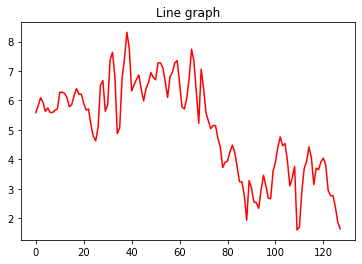

In [54]:
y = np.array(list(i.item() for i in train_dataset[0][0][0][2]))
x = np.arange(0, 128)
plt.title("Line graph")
plt.plot(x, y, color="red")

In [55]:
train_dataset[9900][1]

ValueError: could not broadcast input array from shape (0,3) into shape (128,3)

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # convolutional layer (sees 3x6x128 image tensor)
        self.conv1 = nn.Conv2d(3, 64, (3,5), stride=3, padding=0)
    
        # convolutional layer (sees 64x2x38 tensor)
        self.conv2 = nn.Conv2d(64, 128, (2,3), padding=0)
        # output tensor size is 128x1x40
        

        self.fc1 = nn.Linear(128 * 1 * 40 , 512)
        
        # linear Output layer (512 -> 128)
        self.fc2 = nn.Linear(512, 128)
        
        # linear Output layer (128 -> 18)
        self.fc3 = nn.Linear(128, 7)
        
        self.dropout = nn.Dropout(0.25)
        
        self.relu = nn.ReLU()
      

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        
        x = self.relu(self.conv1(x))
        
        x = self.relu(self.conv2(x))

        x = x.view(-1, 128 * 1 * 40)

        x = self.relu(self.fc1(x))

        x = self.relu(self.fc2(x))
        
        x = self.dropout(x)

        x = self.fc3(x)
        
        return x

model = ConvNet().to(device)
model

NameError: name 'device' is not defined

### Run self supervised model and Evaluate

In [66]:
from sklearn.model_selection import KFold
learning_rate = 0.001
epochs = 6
batch_size = 32
K_folds = 4
kfold = KFold(n_splits=K_folds,shuffle=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [67]:
def k_fold_train_loop(data_loader,model,device,loss_fn,optimizer,print_every_n=500):
    model.train()
    size = len(data_loader.sampler)
    num_batches = len(data_loader)
    train_loss=0
    tp=0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.long)
        pred = model(X)
        
        loss = loss_fn(pred,y)
        train_loss += loss
        tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%print_every_n==0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss={loss:.3f}, {current} samples / {size}')
        
    train_loss /= num_batches
    train_acc = tp/size    
        
    return train_loss,train_acc

In [68]:
def k_fold_validation_loop(data_loader,model,device,loss_fn):
    y_pred_list, y_true_list = [], []
    model.eval()
    num_batches = len(data_loader)
    size=len(data_loader.sampler)
    test_loss=0
    tp=0
    with torch.no_grad():
        for batch,(X,y) in enumerate(data_loader):
            X = X.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)
            pred = model(X)
            y_pred = pred.argmax(1)
            test_loss += loss_fn(pred,y).item()
            tp += (y==pred.argmax(1)).type(torch.float).sum().item()
            y_pred_list.extend(y_pred.cpu().numpy())
            y_true_list.extend(y.cpu().numpy())
        
    test_loss /= num_batches
    test_acc = tp/size
    return test_loss,test_acc, y_pred_list,y_true_list

In [69]:
torch.cuda.empty_cache()
folds = {}
y_value_last_epoch_fold = {}
fold_val_acc = 0
best_fold = -1

history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}

for fold, (train_ids,val_ids) in enumerate(kfold.split(train_dataset)):

    print(f'Starting fold {fold}')

    # split training dataset to training and validation
    train_sub_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sub_sampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler = train_sub_sampler)
    test_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler = val_sub_sampler)

    st = time.time()
        
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}')

        # train epoch
        train_epoch_loss, train_epoch_acc = k_fold_train_loop(train_loader,model,device,loss_fn,optimizer)

        val_loss, val_acc, y_true_list, y_pred_list = k_fold_validation_loop(test_loader,model,device,loss_fn)

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.4f} % AVG Val Acc {:.4f} %".format(epoch + 1,
                                                                                  epochs,
                                                                                  train_epoch_loss,
                                                                                  val_loss,
                                                                                  train_epoch_acc,
                                                                                  val_acc))
        history['train_loss'].append(train_epoch_loss.detach().cpu().numpy())
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_acc'].append(val_acc)   
        
        if (epoch == epochs-1):
            y_value_last_epoch_fold[fold] = y_true_list, y_pred_list
        
    if val_acc > fold_val_acc:
        fold_val_acc=val_acc
        best_fold = fold
        torch.save(model.state_dict(), f'model_weights_fold_{fold}.pth')
    
    et=time.time()
    total_fold_time = et-st
    history["time"]=total_fold_time
    folds[fold]=history

Starting fold 0
Starting epoch 1
loss=1.950, 0 samples / 4526
Epoch:1/6 AVG Training Loss:1.276 AVG Val Loss:0.780 AVG Training Acc 0.4965 % AVG Val Acc 0.6932 %
Starting epoch 2
loss=0.784, 0 samples / 4526
Epoch:2/6 AVG Training Loss:0.665 AVG Val Loss:0.504 AVG Training Acc 0.7702 % AVG Val Acc 0.8363 %
Starting epoch 3
loss=0.429, 0 samples / 4526
Epoch:3/6 AVG Training Loss:0.430 AVG Val Loss:0.538 AVG Training Acc 0.8478 % AVG Val Acc 0.8158 %
Starting epoch 4
loss=0.547, 0 samples / 4526
Epoch:4/6 AVG Training Loss:0.337 AVG Val Loss:0.567 AVG Training Acc 0.8853 % AVG Val Acc 0.8131 %
Starting epoch 5
loss=0.628, 0 samples / 4526
Epoch:5/6 AVG Training Loss:0.290 AVG Val Loss:0.494 AVG Training Acc 0.9039 % AVG Val Acc 0.8396 %
Starting epoch 6
loss=0.176, 0 samples / 4526
Epoch:6/6 AVG Training Loss:0.195 AVG Val Loss:0.486 AVG Training Acc 0.9339 % AVG Val Acc 0.8648 %
Starting fold 1
Starting epoch 1
loss=0.205, 0 samples / 4526
Epoch:1/6 AVG Training Loss:0.260 AVG Val Loss

In [85]:
def EvaluateSubjects(y_true_list,y_pred_list):    
    cm = confusion_matrix(y_true_list, y_pred_list, normalize = 'true')
    subjects = set(y_true_list + y_pred_list)
    labels = [ids_to_classes[x] for x in subjects]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(15,15))
    print('\nFold: {}'.format(fold+1))
    print('Accuracy: {:.3f}'.format(accuracy_score(y_true_list, y_pred_list)))
    print('weighted Recall: {:.3f}'.format(recall_score(y_true_list, y_pred_list, average='weighted')))
    print('weighted Precision: {:.3f}'.format(precision_score(y_true_list, y_pred_list, average='weighted')))
    print('weighted F1-score: {:.3f}'.format(f1_score(y_true_list, y_pred_list, average='weighted')))
    disp.plot(ax=ax, xticks_rotation = 'vertical')

In [87]:
label = 'subject_id'
model.load_state_dict(torch.load(f'model_weights_fold_{best_fold}.pth'))
test_dataset = cnn_dataset(label, test_data, WINDOW_SIZE, STEP, train_transforms)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)
test_loss,test_acc , y_pred_list , y_true_list=test_loop(test_loader,model,device,loss_fn)
print("test loss : " + str(test_loss))
print("test accuracy : " + str(test_acc))

accuracy = 0.8141153081510935, test_loss = 1.090023
test loss : 1.0900225917483488
test accuracy : 0.8141153081510935



Fold: 4
Accuracy: 0.814
weighted Recall: 0.814
weighted Precision: 0.819
weighted F1-score: 0.813


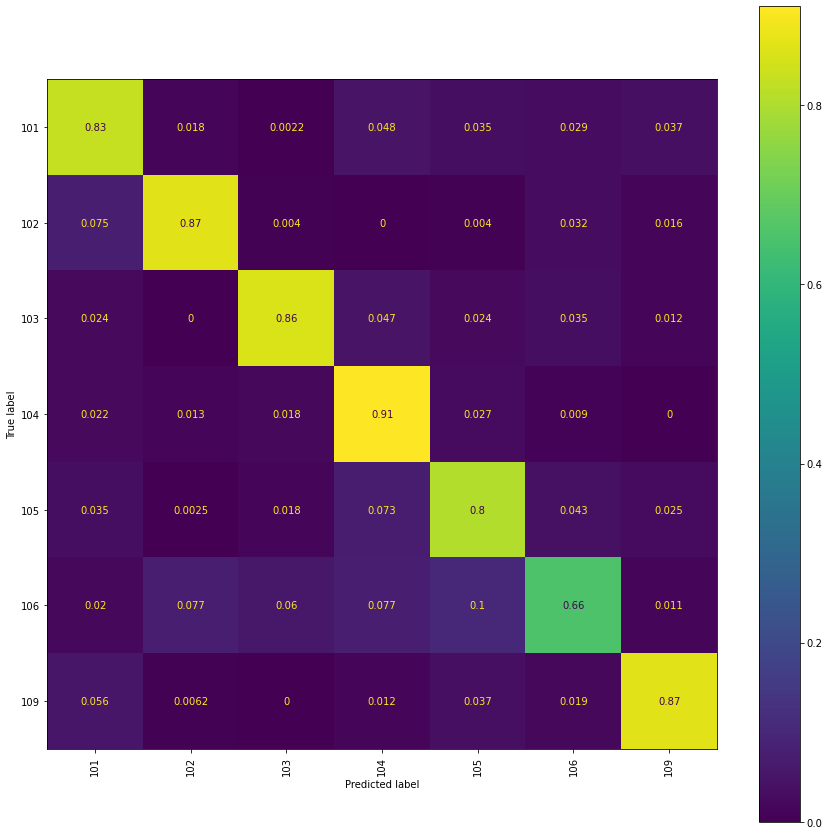

In [86]:
EvaluateSubjects(y_true_list,y_pred_list)

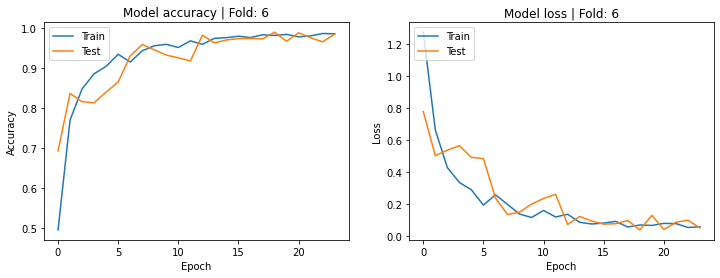

In [88]:
plot_acc_loss(5,history)

In [89]:
torch.save(model, 'models/cnn_subject_classification.pt')

## Take Trained Self supervised model, omit layers and connect to lstm model

In [130]:
train_data, test_data = get_train_test_data_with_stride(1)
    
train_data = train_data.drop(columns=['heart rate (bpm)', 'timestamp(s)'])
train_data['activityID'] = train_data.pop('activityID')
train_data['subject_id'] = train_data.pop('subject_id')

test_data = test_data.drop(columns=['heart rate (bpm)', 'timestamp(s)'])
test_data['activityID'] = test_data.pop('activityID')
test_data['subject_id'] = test_data.pop('subject_id')

In [131]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x = train_data.activityID
le.fit(x)
train_data.activityID = le.transform(train_data.activityID)
test_data.activityID = le.transform(test_data.activityID)

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 9, 8: 10, 9: 11, 10: 12, 11: 13, 12: 16, 13: 17, 14: 18, 15: 19, 16: 20, 17: 24}


In [132]:
train_data

,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,IMU chest acceleration 3 16g,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,activityID,subject_id
0,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,0.124482,9.65003,-1.65181,0.036668,0.016559,-0.052791,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,0,101
1,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,0.200711,9.64980,-1.65043,0.019343,-0.024304,-0.059843,9.69762,-1.884380,-0.020804,0.020882,0.000945,0.006007,0,101
2,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,0.270277,9.72331,-1.88174,-0.001428,0.038466,-0.046464,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,0,101
3,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,0.236737,9.72447,-1.72746,0.017277,-0.048547,-0.074946,9.66370,-1.847140,0.094385,-0.032514,-0.018844,0.026950,0,101
4,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,0.352225,9.72437,-1.68665,0.000275,-0.013352,-0.039315,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,0,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060189,-6.42779,6.84232,2.80728,-0.021124,0.107389,0.043537,1.874740,9.22118,-2.97394,0.124537,0.070576,-0.075640,9.26409,-0.561116,-3.660880,-0.013752,0.011737,-0.011313,16,109
2060190,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,1.798210,9.10846,-2.97496,0.095952,0.061084,-0.058146,9.30900,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,16,109
2060191,-6.41763,6.57977,3.15471,-0.014853,0.079020,0.041868,1.987740,9.14526,-3.01037,0.124518,0.063809,-0.101471,9.30959,-0.069368,-3.470520,-0.010825,-0.025462,-0.057343,16,109
2060192,-6.46049,6.42730,3.03912,0.012556,0.068029,0.050227,2.135430,9.06844,-3.16233,0.113642,0.079775,-0.084217,9.23414,-0.182800,-3.470590,-0.019402,-0.002942,-0.033522,16,109


In [133]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [144]:
class cnn_lstm_model(nn.Module):
    def __init__(self,n_features,n_classes,n_hidden=128,n_layer=1):
        super(cnn_lstm_model, self).__init__()
        # convolutional layer (sees 3x6x128 image tensor)
        self.conv1 = nn.Conv2d(3, 64, (3,16), stride=3, padding=0)

        # convolutional layer (sees 64x2x38 tensor)
        self.conv2 = nn.Conv2d(64, 128, (2,3), padding=0)
        # output tensor size is 128x1x36

        self.relu = nn.ReLU()

        self.lstm  = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layer,
            batch_first=True
        )

        self.fc1 = nn.Linear(n_hidden,18)
      

    def forward(self, x):
        # add sequence of convolutional and max pooling layers

        # 3x6x128
        x = self.relu(self.conv1(x))

        # 64x2x38
        x = self.relu(self.conv2(x))

        # 128x1x36
        x = torch.squeeze(x,-2)

        # 128x36
        x = torch.transpose(x, 1, 2)
        # 36x128
        
        self.lstm.flatten_parameters()

        _,(hidden,_) = self.lstm(x)

        out = hidden[-1]

        return self.fc1(out)

    
model = cnn_lstm_model(128, 18).to(device)
model

cnn_lstm_model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 16), stride=(3, 3))
  (conv2): Conv2d(64, 128, kernel_size=(2, 3), stride=(1, 1))
  (relu): ReLU()
  (lstm): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=18, bias=True)
)

## Run and Evaluate new combined model

In [145]:
cnn_subject_classification_model = torch.load('models/cnn_subject_classification.pt')
model.conv1.weight = cnn_subject_classification_model.conv1.weight
model.conv1.bias = cnn_subject_classification_model.conv1.bias
model.conv1.requires_grad = False

model.conv2.weight = cnn_subject_classification_model.conv2.weight
model.conv2.bias = cnn_subject_classification_model.conv2.bias
model.conv2.requires_grad = False

In [ ]:
folds = {}
y_value_last_epoch_fold = {}
validations = [[103,104],[105,106],[102]]
WINDOW_SIZE = 128
STEP = 8
BATCH_SIZE = 128
LABEL = 'activityID'
learning_rate = 0.0001
epochs = 4
fold_val_acc = 0
best_fold = -1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for fold, validation_list in enumerate(validations):
    if fold == 1:
        model.conv1.requires_grad = True
        model.conv2.requires_grad = True
    print(f'Starting fold {fold}')

    # split training dataset to training and validation
    train_df,validation_df = split_train_validation(train_data,validation_list)
    train_dataset = cnn_dataset(LABEL, train_df, WINDOW_SIZE, STEP, train_transforms)
    validation_dataset = cnn_dataset(LABEL, validation_df,WINDOW_SIZE, STEP, train_transforms)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
    validation_loader = DataLoader(validation_dataset,batch_size=BATCH_SIZE,shuffle=True)
    
    
    st = time.time()
    history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}  
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}')
        # train epoch
        train_epoch_loss,train_epoch_acc = train_loop(train_loader,model,device,loss_fn,optimizer)
        val_loss,val_acc,y_pred_list,y_true_list  = val_loop(validation_loader,model,device,loss_fn)
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.4f} % AVG Val Acc {:.4f} %".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             train_epoch_loss,
                                                                                                             val_loss,
                                                                                                             train_epoch_acc,
                                                                                                             val_acc))
        history['train_loss'].append(train_epoch_loss.detach().cpu().numpy())
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch == epochs-1):
            y_value_last_epoch_fold[fold] = y_true_list, y_pred_list
        
        if val_acc > fold_val_acc:
            fold_val_acc=val_acc
            best_fold = fold
            torch.save(model.state_dict(), f'model_weights_fold_{fold}.pth')
    
    et=time.time()
    total_fold_time = et-st
    history["time"]=total_fold_time
    folds[fold]=history

In [150]:
model.load_state_dict(torch.load(f'model_weights_fold_{best_fold}.pth'))
test_dataset = cnn_dataset(LABEL, test_data, WINDOW_SIZE, STEP, train_transforms)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)
test_loss,test_acc , y_pred_list , y_true_list=test_loop(test_loader,model,device,loss_fn)
print("test loss : " + str(test_loss))
print("test accuracy : " + str(test_acc))

accuracy = 0.4123016219860901, test_loss = 2.940972
test loss : 2.940971559921932
test accuracy : 0.4123016219860901



Fold: 3
Accuracy: 0.412


C:\Users\Tomer\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



weighted Recall: 0.412
weighted Precision: 0.511
weighted F1-score: 0.425


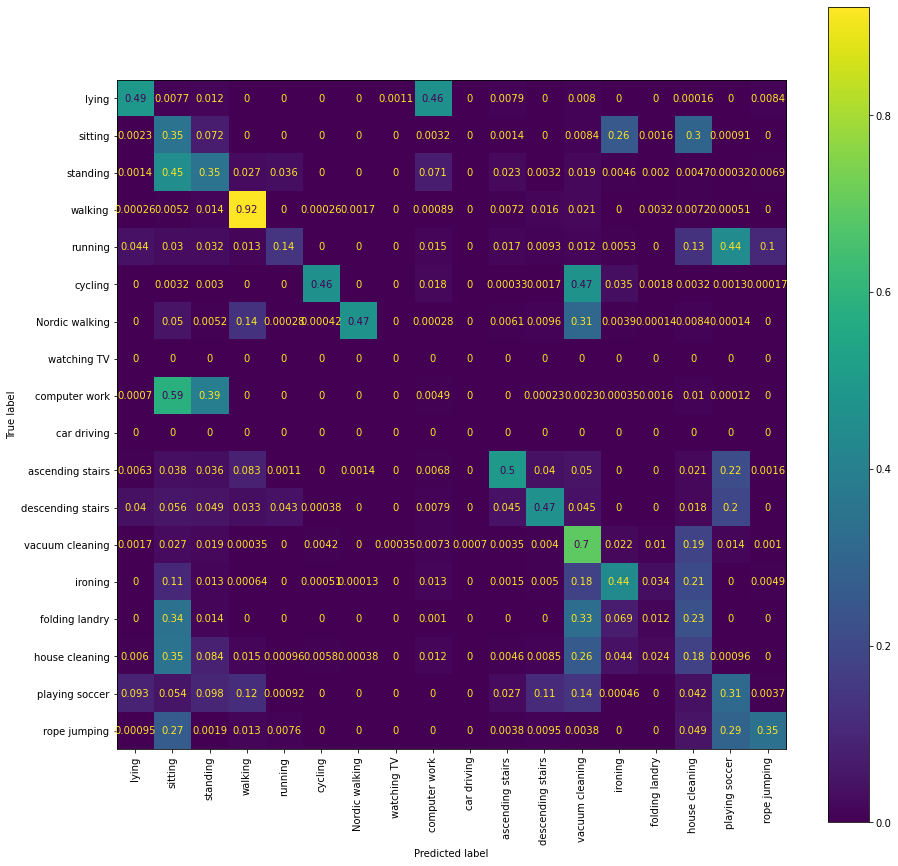

In [151]:
Evaluate(y_true_list,y_pred_list)


Fold: 1
Accuracy: 0.627
weighted Precision: 0.777
weighted F1-score: 0.673


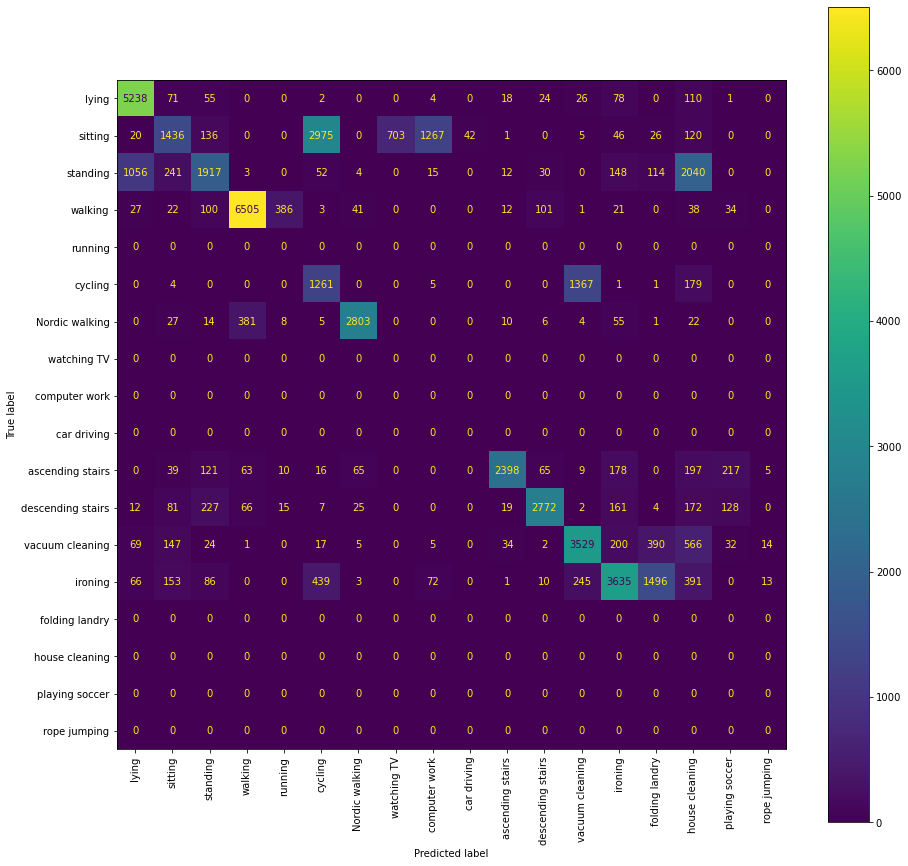

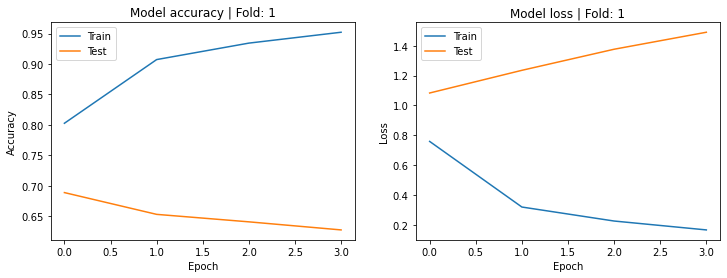


Fold: 2
Accuracy: 0.772
weighted Precision: 0.832
weighted F1-score: 0.777


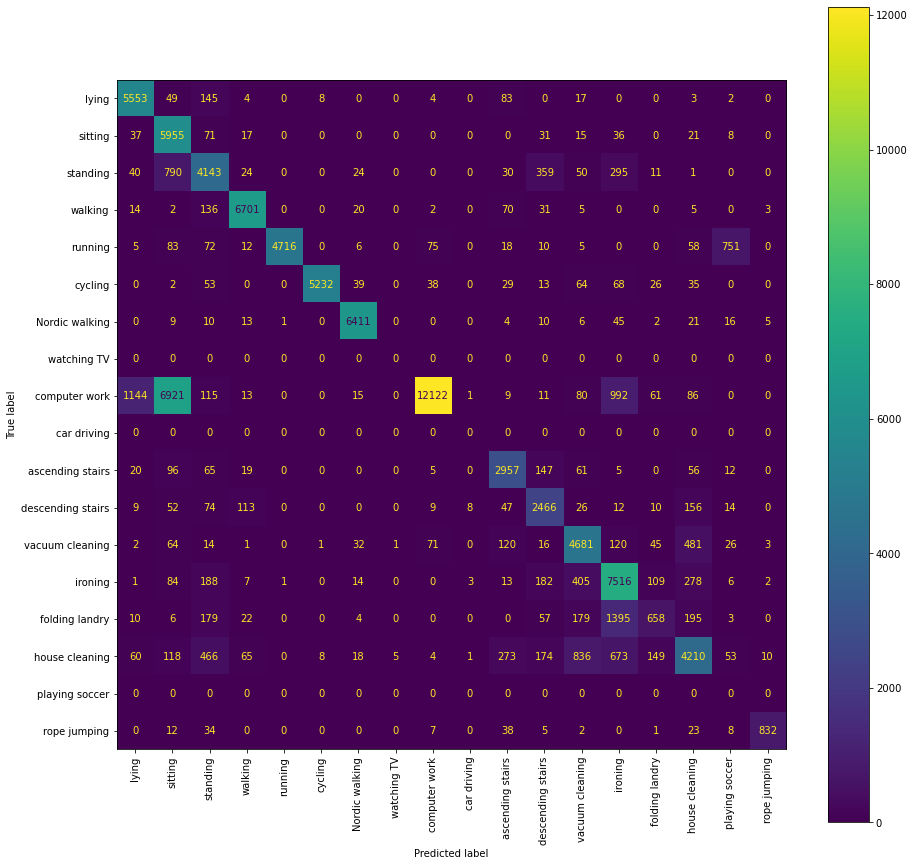

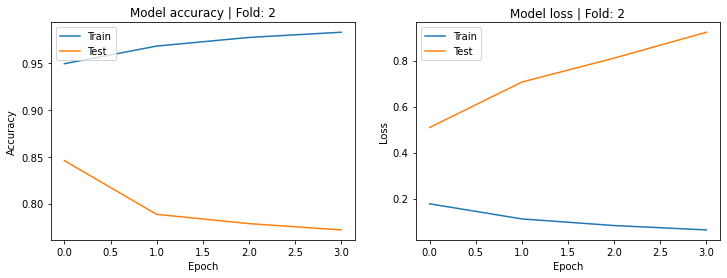


Fold: 3
Accuracy: 0.934
weighted Precision: 0.960
weighted F1-score: 0.946


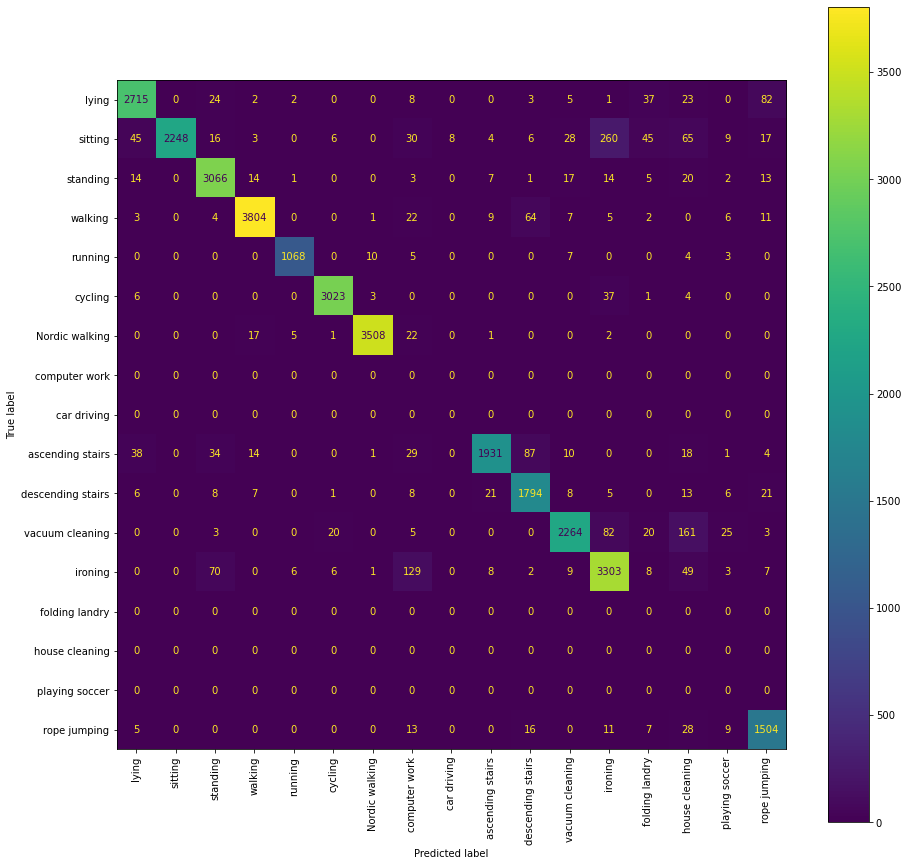

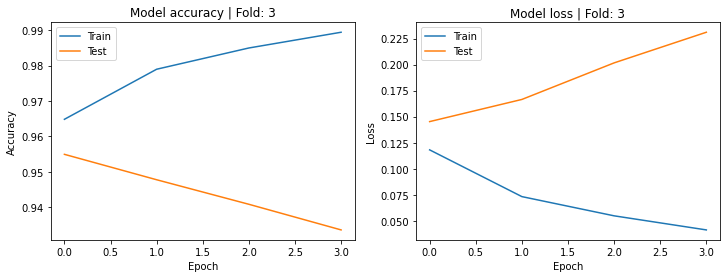

In [152]:
fold_metrics(y_value_last_epoch_fold, folds)

## Emprove Lstm model

the following improvements applied to the lstm model are:
 - a bigger window size and step that will hopefully result in a more generalizing model with less overfitting.
 - a more complex structure after the lstm layer that could contribute to the models ability to distinguish similar activities.

In [50]:
train_data, test_data = get_train_test_data_with_stride(2)
train_data.drop(['heart rate (bpm)'],axis=1,inplace = True)
test_data.drop(['heart rate (bpm)'],axis=1,inplace = True)

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x = train_data.activityID
le.fit(x)
train_data.activityID = le.transform(train_data.activityID)
test_data.activityID = le.transform(test_data.activityID)

In [52]:
train_data

,timestamp(s),activityID,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,...,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,subject_id
0,0.00,0,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,0.124482,9.65003,...,0.036668,0.016559,-0.052791,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,101
1,0.02,0,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,0.270277,9.72331,...,-0.001428,0.038466,-0.046464,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,101
2,0.04,0,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,0.352225,9.72437,...,0.000275,-0.013352,-0.039315,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,101
3,0.06,0,2.41148,7.59780,5.93915,0.190837,0.003116,0.038762,0.274553,9.61139,...,0.024609,-0.022451,-0.033739,9.65839,-1.807560,-0.098862,0.036814,-0.032277,-0.006866,101
4,0.08,0,2.25096,7.78598,5.62821,0.204098,-0.068256,0.050000,0.349738,9.64854,...,0.017893,-0.018287,-0.037089,9.77727,-1.810200,0.133911,0.039346,0.020393,-0.011880,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030092,20601.84,16,-6.65239,6.76887,2.88114,-0.015895,0.016644,0.054881,1.942660,9.10617,...,-0.113574,0.163391,-0.138400,9.45859,0.005942,-3.508050,-0.008172,-0.033159,0.059177,109
1030093,20601.86,16,-6.46478,6.76707,2.84547,-0.052073,0.055146,0.048967,2.068550,9.14606,...,-0.006634,0.139468,-0.122753,9.41899,-0.411475,-3.505860,-0.016554,-0.031694,0.089890,109
1030094,20601.88,16,-6.50257,6.76736,2.84490,-0.059496,0.102580,0.015306,1.982320,9.25692,...,0.059470,0.089693,-0.092369,9.41650,-0.676934,-3.542830,-0.041141,0.031002,0.024244,109
1030095,20601.90,16,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,1.798210,9.10846,...,0.095952,0.061084,-0.058146,9.30900,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,109


In [53]:
id_to_activity ={
    0:"lying",
    1:'sitting',
    2:'standing',
    3:'walking',
    4:'running',
    5:'cycling',
    6:'Nordic walking',
    7:'watching TV',
    8:'computer work',
    9:'car driving',
    10:'ascending stairs',
    11:'descending stairs',
    12:'vacuum cleaning',
    13:'ironing',
    14:'folding landry',
    15:'house cleaning',
    16:'playing soccer',
    17:'rope jumping'
}

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [55]:
class Analysis_dataset(Dataset):    
    def __init__(self,data,window_size, step):
        self.data = data
        self.win = window_size
        self.step = step
        
    def __len__(self):
        return int(((len(self.data) - self.win) / self.step) + 1)
    
    def __getitem__(self,idx):
        
        X=self.data.iloc[(idx * self.step) : (idx * self.step) + self.win, :]
        Y = X['activityID'].value_counts().keys()[0]
        X=X.drop(["timestamp(s)", 'activityID','subject_id'], axis = 1)
        X = X.to_numpy()
        X = torch.from_numpy(X).float()
        return X, Y
    
    def get_distribution(self):
        l=[]
        for i in range(self.__len__()):
            l.append(self.__getitem__(i)[1])
        
        return l

In [65]:
class LSTM_Model(nn.Module):
    def __init__(self,n_features,n_classes,n_hidden=128,n_layer=1):
        super().__init__()
        
        self.lstm  = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layer,
            batch_first=True
        )
        
        self.fc1 = nn.Linear(n_hidden,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,n_classes)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    
    def forward(self,x):
        self.lstm.flatten_parameters()
        _,(hidden,_) = self.lstm(x)
        
        out = hidden[-1]
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        
        return out

In [66]:
model = LSTM_Model(18,18).to(device)
# summary(model, input_size=(64, 64, 18))

In [67]:
folds = {}
y_value_last_epoch_fold = {}
validations = [[103,104],[105,106],[102]]
WINDOW_SIZE = 256
STEP = 128
BATCH_SIZE = 32
LABEL = 'activityID'
learning_rate = 0.0001
epochs = 10
fold_val_acc = 0
best_fold = -1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for fold, validation_list in enumerate(validations):
    print(f'Starting fold {fold}')

    # split training dataset to training and validation
    train_df,validation_df = split_train_validation(train_data,validation_list)
    train_dataset = Analysis_dataset(train_df, WINDOW_SIZE, STEP)
    validation_dataset = Analysis_dataset(validation_df,WINDOW_SIZE, STEP)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
    validation_loader = DataLoader(validation_dataset,batch_size=BATCH_SIZE,shuffle=True)
    
    
    st = time.time()
    history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}  
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}')
        # train epoch
        train_epoch_loss,train_epoch_acc = train_loop(train_loader,model,device,loss_fn,optimizer)
        val_loss,val_acc,y_pred_list,y_true_list  = val_loop(validation_loader,model,device,loss_fn)
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.4f} % AVG Val Acc {:.4f} %".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             train_epoch_loss,
                                                                                                             val_loss,
                                                                                                             train_epoch_acc,
                                                                                                             val_acc))
        history['train_loss'].append(train_epoch_loss.detach().cpu().numpy())
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch == epochs-1):
            y_value_last_epoch_fold[fold] = y_true_list, y_pred_list
        
        if val_acc > fold_val_acc:
            fold_val_acc=val_acc
            best_fold = fold
            torch.save(model.state_dict(), f'model_weights_fold_{fold}.pth')
    
    et=time.time()
    total_fold_time = et-st
    history["time"]=total_fold_time
    folds[fold]=history

Starting fold 0
Starting epoch 1
loss=2.902, 0 samples / 6477
validatio accuracy = 0.13392857142857142, validation loss = 2.774671
Epoch:1/10 AVG Training Loss:2.778 AVG Val Loss:2.775 AVG Training Acc 0.1583 % AVG Val Acc 0.1339 %
Starting epoch 2
loss=2.378, 0 samples / 6477
validatio accuracy = 0.319515306122449, validation loss = 2.248499
Epoch:2/10 AVG Training Loss:2.284 AVG Val Loss:2.248 AVG Training Acc 0.2853 % AVG Val Acc 0.3195 %
Starting epoch 3
loss=2.299, 0 samples / 6477
validatio accuracy = 0.37563775510204084, validation loss = 2.003283
Epoch:3/10 AVG Training Loss:1.981 AVG Val Loss:2.003 AVG Training Acc 0.3733 % AVG Val Acc 0.3756 %
Starting epoch 4
loss=1.912, 0 samples / 6477
validatio accuracy = 0.3832908163265306, validation loss = 1.894721
Epoch:4/10 AVG Training Loss:1.818 AVG Val Loss:1.895 AVG Training Acc 0.4403 % AVG Val Acc 0.3833 %
Starting epoch 5
loss=1.692, 0 samples / 6477
validatio accuracy = 0.4413265306122449, validation loss = 1.828636
Epoch:5/1

In [68]:
for i in range(len(folds)):
    print_fold_info(folds[i],i)

fold metrics of last epoch for fold 1
train loss : 1.3161811
validation loss : 1.492992522765179
train accuracy : 0.6038289331480624
validation accuracy : 0.5860969387755102
fold time : 1.8892545183499654 minutes
fold metrics of last epoch for fold 2
train loss : 1.0355023
validation loss : 1.2141324319738023
train accuracy : 0.6879460745440127
validation accuracy : 0.680106631122959
fold time : 1.8263206521670023 minutes
fold metrics of last epoch for fold 3
train loss : 0.7802146
validation loss : 1.518139949068427
train accuracy : 0.7728177423940858
validation accuracy : 0.599406528189911
fold time : 1.9076523184776306 minutes


In [69]:
avg_train_loss = np.mean([np.mean(folds[i]['train_loss'][len(folds[i]['train_loss'])-1]) for i in range(len(folds))])
avg_valt_loss =  np.mean([np.mean(folds[i]['val_loss'][len(folds[i]['val_loss'])-1]) for i in range(len(folds))])
avg_train_acc = np.mean([np.mean(folds[i]['train_acc'][len(folds[i]['train_acc'])-1]) for i in range(len(folds))])
avg_val_acc = np.mean([np.mean(folds[i]['val_acc'][len(folds[i]['val_acc'])-1]) for i in range(len(folds))])
avg_fold_time = np.mean([folds[i]['time'] for i in range(len(folds))])/60
print('Performance of {} fold cross validation'.format(3))
print("Average Training Loss: {:.4f} \t Average Val Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Val Acc: {:.3f} \t Average Fold time: {:.34f} minutes".format(avg_train_loss,avg_valt_loss,avg_train_acc,avg_val_acc,avg_fold_time))  

Performance of 3 fold cross validation
Average Training Loss: 1.0440 	 Average Val Loss: 1.4084 	 Average Training Acc: 0.688 	 Average Val Acc: 0.622 	 Average Fold time: 1.8744091629981993740727830299874768 minutes


In [74]:
model.load_state_dict(torch.load(f'model_weights_fold_{best_fold}.pth'))
test_dataset = Analysis_dataset(test_data, WINDOW_SIZE, STEP)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)
test_loss,test_acc , y_pred_list , y_true_list=test_loop(test_loader,model,device,loss_fn)
print("test loss : " + str(test_loss))
print("test accuracy : " + str(test_acc))

accuracy = 0.45123900879296563, test_loss = 2.024283
test loss : 2.024282677264153
test accuracy : 0.45123900879296563



Fold: 3
Accuracy: 0.451
weighted Recall: 0.451
weighted Precision: 0.500
weighted F1-score: 0.420


C:\Users\Tomer\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\Tomer\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



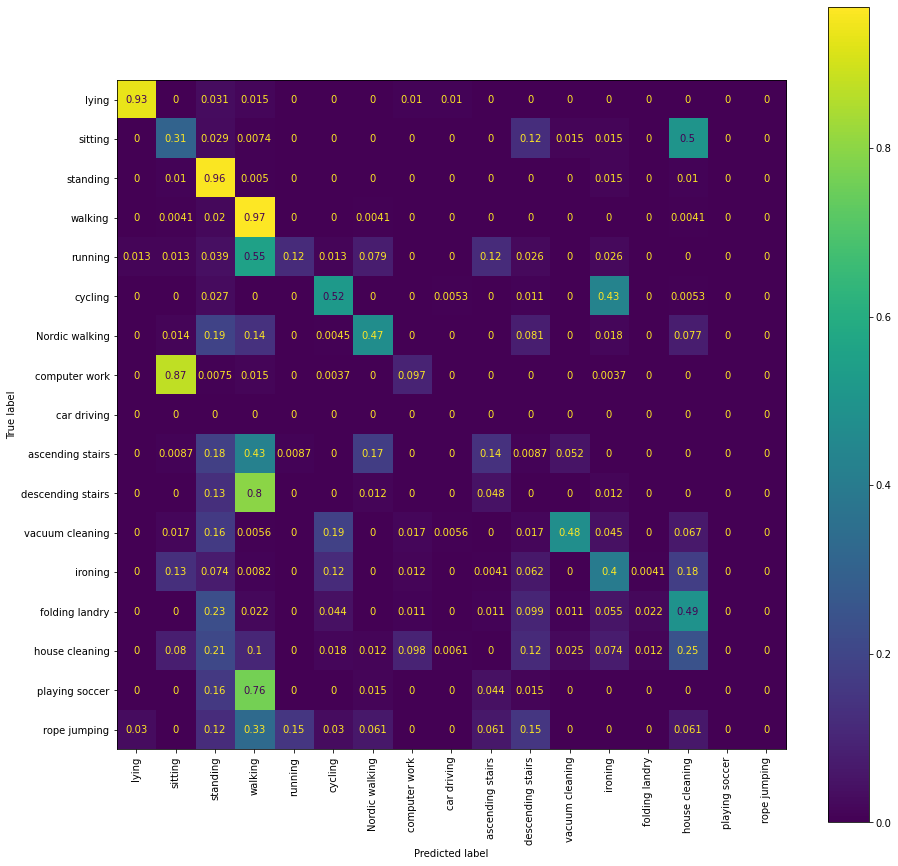

In [75]:
Evaluate(y_true_list,y_pred_list)


Fold: 1
Accuracy: 0.586
weighted Precision: 0.673
weighted F1-score: 0.565


C:\Users\Tomer\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



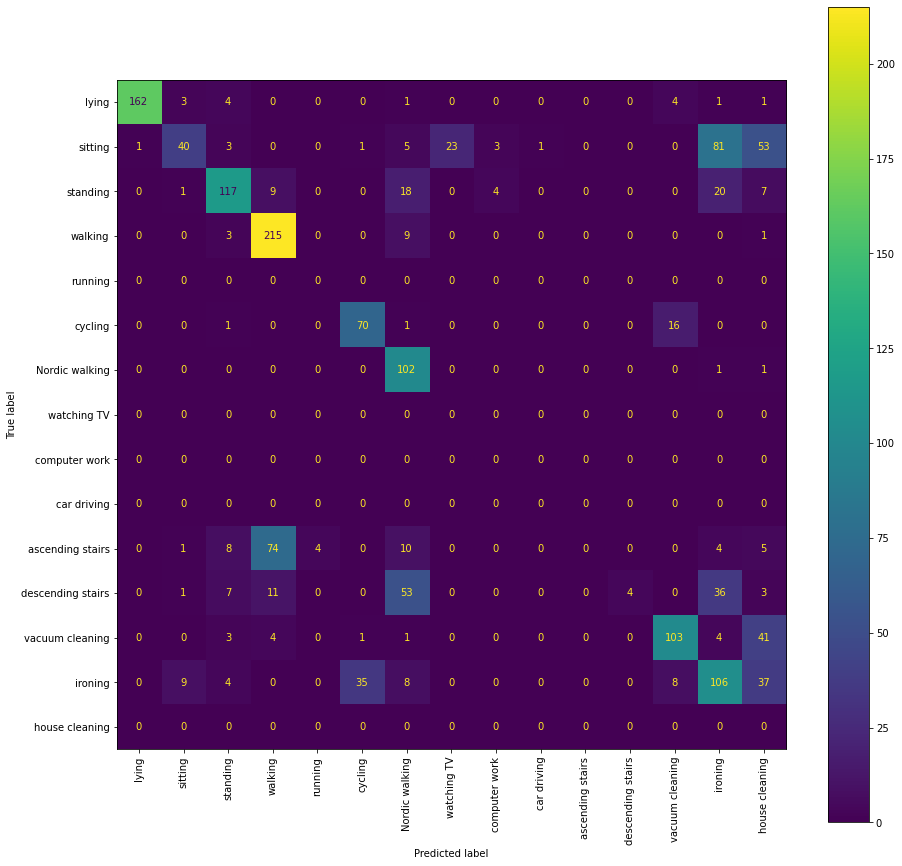

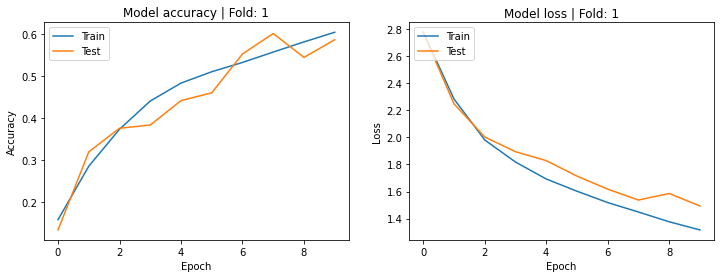


Fold: 2
Accuracy: 0.680
weighted Precision: 0.734
weighted F1-score: 0.682


C:\Users\Tomer\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



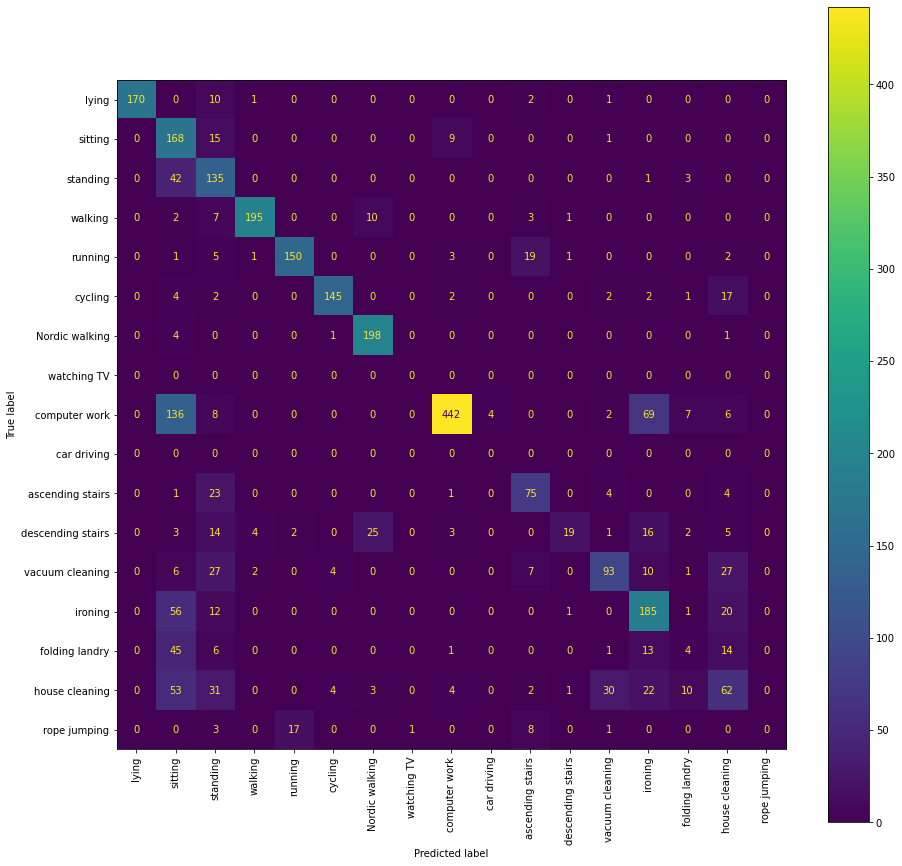

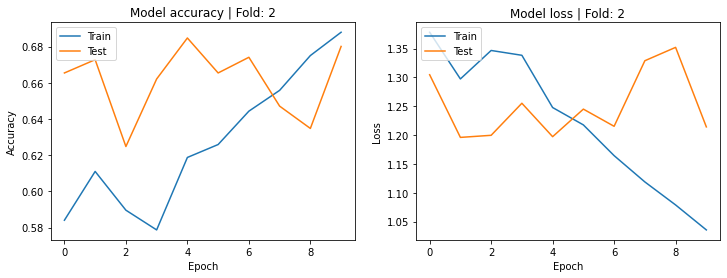


Fold: 3
Accuracy: 0.599
weighted Precision: 0.718
weighted F1-score: 0.578


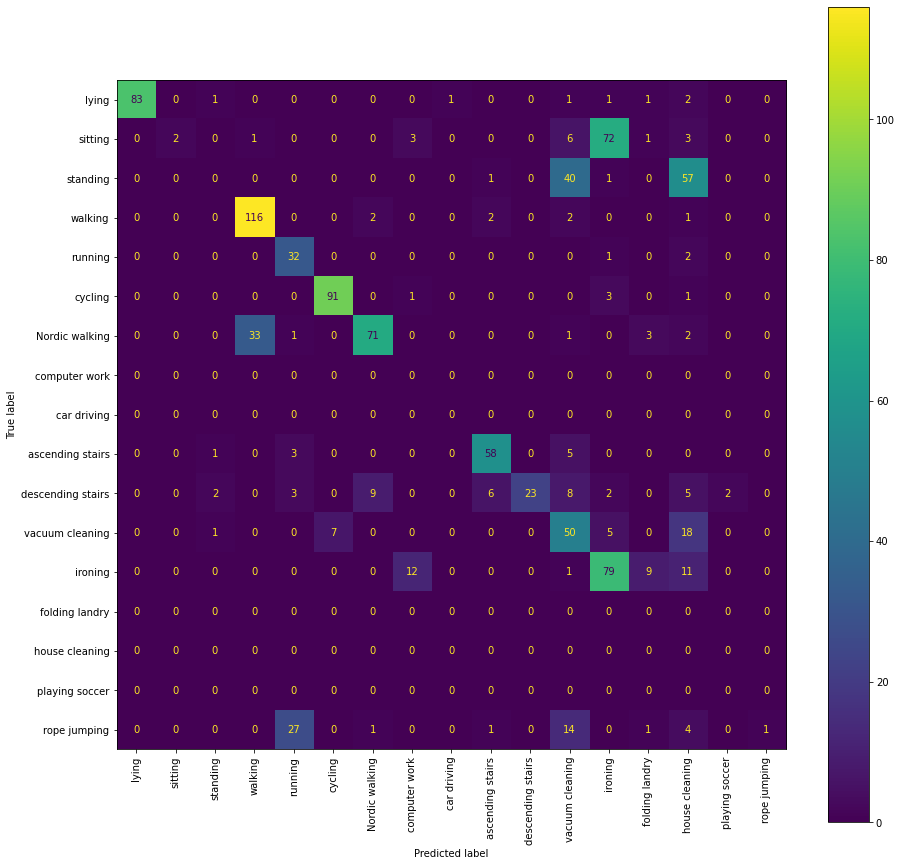

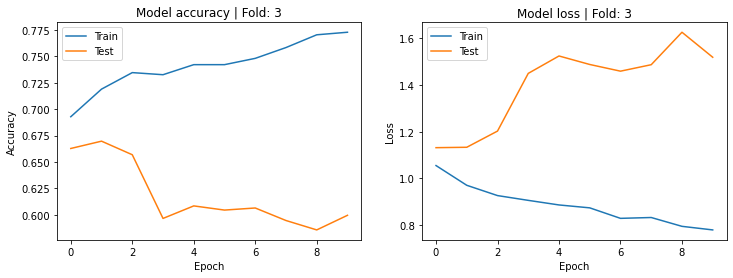

In [76]:
fold_metrics(y_value_last_epoch_fold, folds)

In [77]:
torch.save(model, 'models/improved_lstm_model.pt')

## Emprove combined model

choosing a bigger window size comes with disatvantages, as the lstm layer has to deal with a much bigger sequence dimension. By combining an improved layer of cnn we can reduct the complexity and nosie that comes with choosing a bigger window.
this can allow us to sample a bigger window and still having a relativly thin sequence dimension for the lstm's input.

this is the main approach for the emproved combined model as the additions include:
 - adding pooling layers to reduce sequence dimension.
 - adding a third convolution layer
 - reducing the lr and step as the model is much more complex than the privious models.

In [146]:
train_data, test_data = get_train_test_data_with_stride(1)
    
train_data = train_data.drop(columns=['heart rate (bpm)', 'timestamp(s)'])
train_data['activityID'] = train_data.pop('activityID')
train_data['subject_id'] = train_data.pop('subject_id')

test_data = test_data.drop(columns=['heart rate (bpm)', 'timestamp(s)'])
test_data['activityID'] = test_data.pop('activityID')
test_data['subject_id'] = test_data.pop('subject_id')

In [147]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x = train_data.activityID
le.fit(x)
train_data.activityID = le.transform(train_data.activityID)
test_data.activityID = le.transform(test_data.activityID)

In [148]:
train_data

,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,IMU chest acceleration 3 16g,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,activityID,subject_id
0,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,0.124482,9.65003,-1.65181,0.036668,0.016559,-0.052791,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,0,101
1,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,0.200711,9.64980,-1.65043,0.019343,-0.024304,-0.059843,9.69762,-1.884380,-0.020804,0.020882,0.000945,0.006007,0,101
2,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,0.270277,9.72331,-1.88174,-0.001428,0.038466,-0.046464,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,0,101
3,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,0.236737,9.72447,-1.72746,0.017277,-0.048547,-0.074946,9.66370,-1.847140,0.094385,-0.032514,-0.018844,0.026950,0,101
4,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,0.352225,9.72437,-1.68665,0.000275,-0.013352,-0.039315,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,0,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060189,-6.42779,6.84232,2.80728,-0.021124,0.107389,0.043537,1.874740,9.22118,-2.97394,0.124537,0.070576,-0.075640,9.26409,-0.561116,-3.660880,-0.013752,0.011737,-0.011313,16,109
2060190,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,1.798210,9.10846,-2.97496,0.095952,0.061084,-0.058146,9.30900,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,16,109
2060191,-6.41763,6.57977,3.15471,-0.014853,0.079020,0.041868,1.987740,9.14526,-3.01037,0.124518,0.063809,-0.101471,9.30959,-0.069368,-3.470520,-0.010825,-0.025462,-0.057343,16,109
2060192,-6.46049,6.42730,3.03912,0.012556,0.068029,0.050227,2.135430,9.06844,-3.16233,0.113642,0.079775,-0.084217,9.23414,-0.182800,-3.470590,-0.019402,-0.002942,-0.033522,16,109


In [149]:
class cnn_lstm_model(nn.Module):
    def __init__(self,n_features,n_classes,n_hidden=128,n_layer=1):
        super(cnn_lstm_model, self).__init__()
        
        # convolutional layer (sees 3x6x256 image tensor)
        self.conv1 = nn.Conv2d(3, 16, (1,6), stride=(1,3), padding=0)
        
        # convolutional layer (sees 16x6x41 image tensor)
        self.conv2 = nn.Conv2d(16, 32, (3,4), stride=(3,1), padding=0)
        
        # convolutional layer (sees 64x2x80 tensor)
        self.conv3 = nn.Conv2d(32, 64, (2,3), padding=0)
        # output tensor size is 128x1x80
        
        self.pool = nn.MaxPool2d((1,2),(1,2))

        self.lstm  = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layer,
            batch_first=True
        )
        
        
        self.fc1 = nn.Linear(n_hidden,64)
        
        self.fc2 = nn.Linear(64,32)
        
        self.fc3 = nn.Linear(32,n_classes)
        
        self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()
      

    def forward(self, x):
        # add sequence of convolutional and max pooling layers

        # 3x6x256
        x = self.relu(self.conv1(x))
        
        # 16x6x82 
        x = self.pool(x)

        #16x6x41
        x = self.relu(self.conv2(x))
    
        # 64x2x38 
        x = self.pool(x)

        # 64x2x19 
        x = self.relu(self.conv3(x))
    
        # 64x2x17 
        x = torch.squeeze(x,-2)
        
        x = torch.transpose(x, 1, 2)

        self.lstm.flatten_parameters()

        _,(hidden,_) = self.lstm(x)
        
        out = hidden[-1]
        
        out = self.dropout(out)
        
        out = self.relu(self.fc1(out))
        
        out = self.dropout(out)
        
        out = self.relu(self.fc2(out))
        
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return out

    
model = cnn_lstm_model(64, 18).to(device)
model

cnn_lstm_model(
  (conv1): Conv2d(3, 16, kernel_size=(1, 6), stride=(1, 3))
  (conv2): Conv2d(16, 32, kernel_size=(3, 4), stride=(3, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=18, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

## Run and Evaluate new emproved combined model

In [152]:
folds = {}
y_value_last_epoch_fold = {}
validations = [[102]]
WINDOW_SIZE = 256
STEP = 32
BATCH_SIZE = 32 
LABEL = 'activityID'
learning_rate = 0.00005
epochs = 14
fold_val_acc = 0
best_fold = -1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for fold, validation_list in enumerate(validations):
    print(f'Starting fold: {fold + 1}')

    # split training dataset to training and validation
    train_df,validation_df = split_train_validation(train_data,validation_list)
    train_dataset = cnn_dataset(LABEL, train_df, WINDOW_SIZE, STEP, train_transforms)
    validation_dataset = cnn_dataset(LABEL, validation_df,WINDOW_SIZE, STEP, train_transforms)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
    validation_loader = DataLoader(validation_dataset,batch_size=BATCH_SIZE,shuffle=True)
    
    
    st = time.time()
    history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}  
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}')
        # train epoch
        train_epoch_loss,train_epoch_acc = train_loop(train_loader,model,device,loss_fn,optimizer)
        val_loss,val_acc,y_pred_list,y_true_list  = val_loop(validation_loader,model,device,loss_fn)
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.4f} % AVG Val Acc {:.4f} %".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             train_epoch_loss,
                                                                                                             val_loss,
                                                                                                             train_epoch_acc,
                                                                                                             val_acc))
        history['train_loss'].append(train_epoch_loss.detach().cpu().numpy())
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch == epochs-1):
            y_value_last_epoch_fold[fold] = y_true_list, y_pred_list
        
        if val_acc > fold_val_acc:
            fold_val_acc=val_acc
            best_fold = fold
            torch.save(model.state_dict(), f'model_weights_fold_{fold}.pth')
    
    et=time.time()
    total_fold_time = et-st
    history["time"]=total_fold_time
    folds[fold]=history

Starting fold: 1
Starting epoch 1
loss=2.858, 0 samples / 51820
loss=2.383, 16000 samples / 51820
loss=1.811, 32000 samples / 51820
loss=1.783, 48000 samples / 51820
validatio accuracy = 0.5336362187151283, validation loss = 1.855457
Epoch:1/14 AVG Training Loss:2.129 AVG Val Loss:1.855 AVG Training Acc 0.3416 % AVG Val Acc 0.5336 %
Starting epoch 2
loss=1.413, 0 samples / 51820
loss=1.479, 16000 samples / 51820
loss=1.347, 32000 samples / 51820
loss=1.150, 48000 samples / 51820
validatio accuracy = 0.6053722301928902, validation loss = 1.444195
Epoch:2/14 AVG Training Loss:1.357 AVG Val Loss:1.444 AVG Training Acc 0.5871 % AVG Val Acc 0.6054 %
Starting epoch 3
loss=1.160, 0 samples / 51820
loss=0.902, 16000 samples / 51820
loss=0.963, 32000 samples / 51820
loss=0.951, 48000 samples / 51820
validatio accuracy = 0.6386896221903395, validation loss = 1.229433
Epoch:3/14 AVG Training Loss:1.065 AVG Val Loss:1.229 AVG Training Acc 0.6855 % AVG Val Acc 0.6387 %
Starting epoch 4
loss=1.017, 

In [153]:
for i in range(len(folds)):
    print_fold_info(folds[i],i)

fold metrics of last epoch for fold 1
train loss : 0.4315229
validation loss : 1.2616707557864468
train accuracy : 0.8784253184098804
validation accuracy : 0.7031723258409055
fold time : 21.75168240070343 minutes


In [154]:
avg_train_loss = np.mean([np.mean(folds[i]['train_loss'][len(folds[i]['train_loss'])-1]) for i in range(len(folds))])
avg_valt_loss =  np.mean([np.mean(folds[i]['val_loss'][len(folds[i]['val_loss'])-1]) for i in range(len(folds))])
avg_train_acc = np.mean([np.mean(folds[i]['train_acc'][len(folds[i]['train_acc'])-1]) for i in range(len(folds))])
avg_val_acc = np.mean([np.mean(folds[i]['val_acc'][len(folds[i]['val_acc'])-1]) for i in range(len(folds))])
avg_fold_time = np.mean([folds[i]['time'] for i in range(len(folds))])/60
print('Performance of {} fold cross validation'.format(3))
print("Average Training Loss: {:.4f} \t Average Val Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Val Acc: {:.3f} \t Average Fold time: {:.34f} minutes".format(avg_train_loss,avg_valt_loss,avg_train_acc,avg_val_acc,avg_fold_time))  

Performance of 3 fold cross validation
Average Training Loss: 0.4315 	 Average Val Loss: 1.2617 	 Average Training Acc: 0.878 	 Average Val Acc: 0.703 	 Average Fold time: 21.7516824007034301757812500000000000 minutes


In [155]:
model.load_state_dict(torch.load(f'model_weights_fold_{best_fold}.pth'))
test_dataset = cnn_dataset(LABEL, test_data, WINDOW_SIZE, STEP, train_transforms)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)
test_loss,test_acc , y_pred_list , y_true_list=test_loop(test_loader,model,device,loss_fn)
print("test loss : " + str(test_loss))
print("test accuracy : " + str(test_acc))

accuracy = 0.4296133479868119, test_loss = 2.548797
test loss : 2.548796790095564
test accuracy : 0.4296133479868119



Fold: 3
Accuracy: 0.542
weighted Recall: 0.542
weighted Precision: 0.666
weighted F1-score: 0.550


C:\Users\Tomer\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



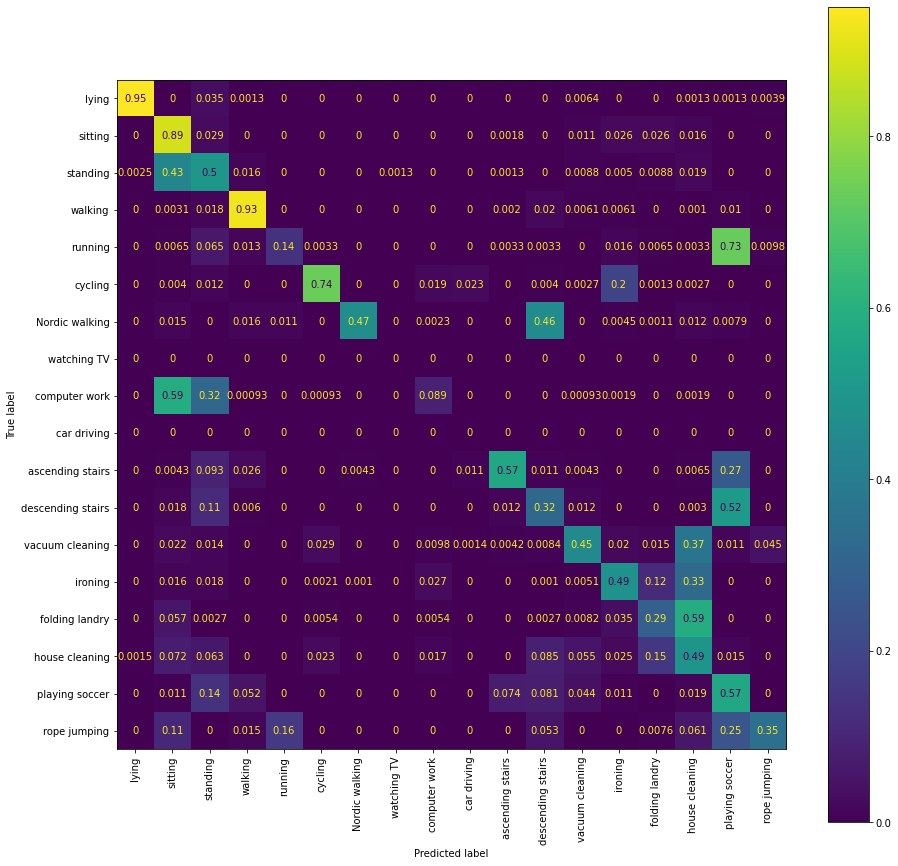

In [105]:
Evaluate(y_true_list,y_pred_list)


Fold: 1
Accuracy: 0.689
weighted Precision: 0.814
weighted F1-score: 0.697


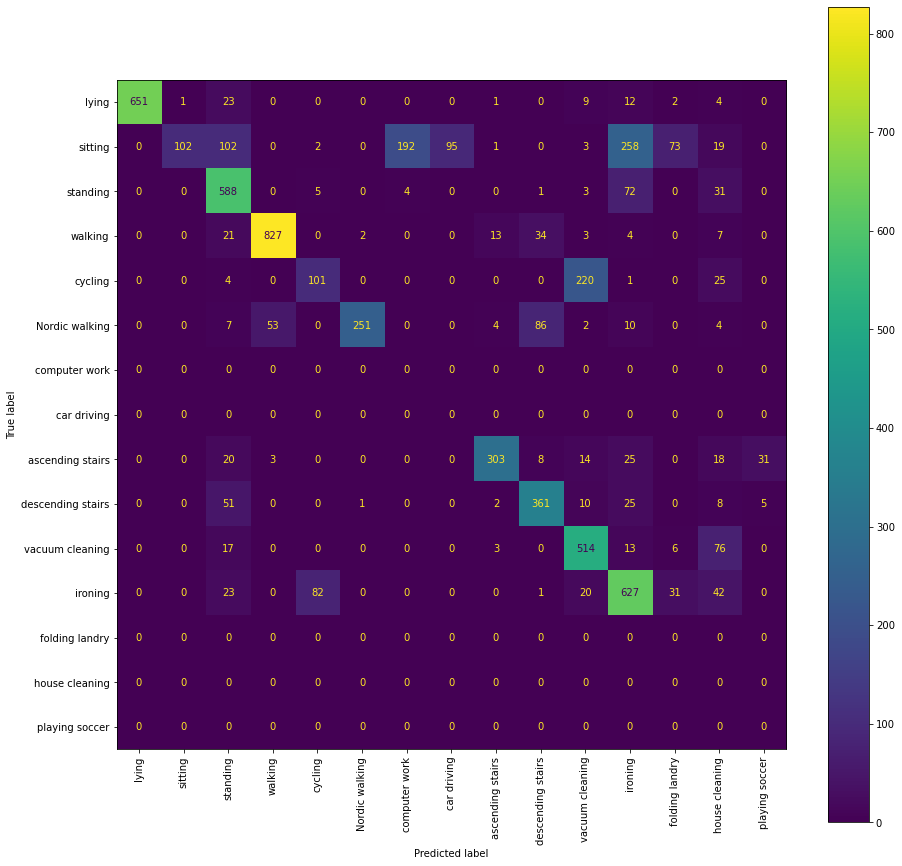

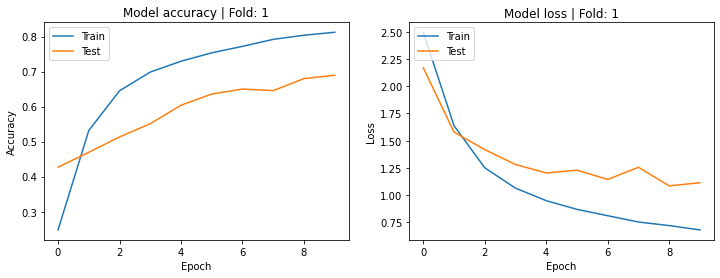


Fold: 2
Accuracy: 0.644
weighted Precision: 0.772
weighted F1-score: 0.652


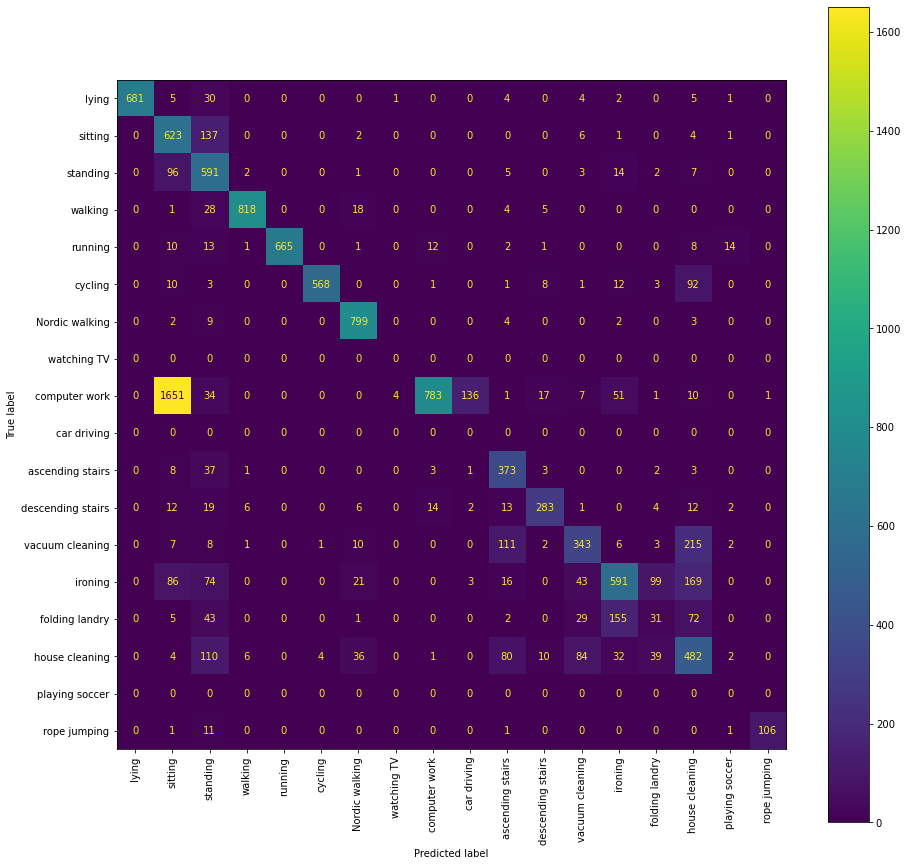

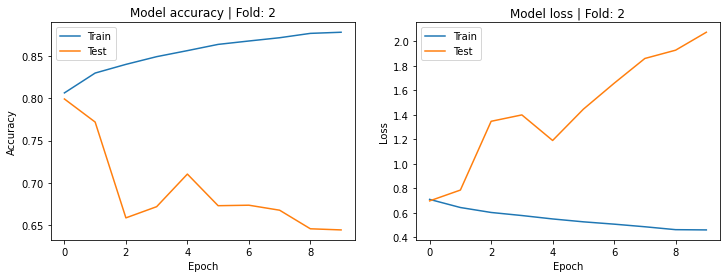


Fold: 3
Accuracy: 0.702
weighted Precision: 0.796
weighted F1-score: 0.737


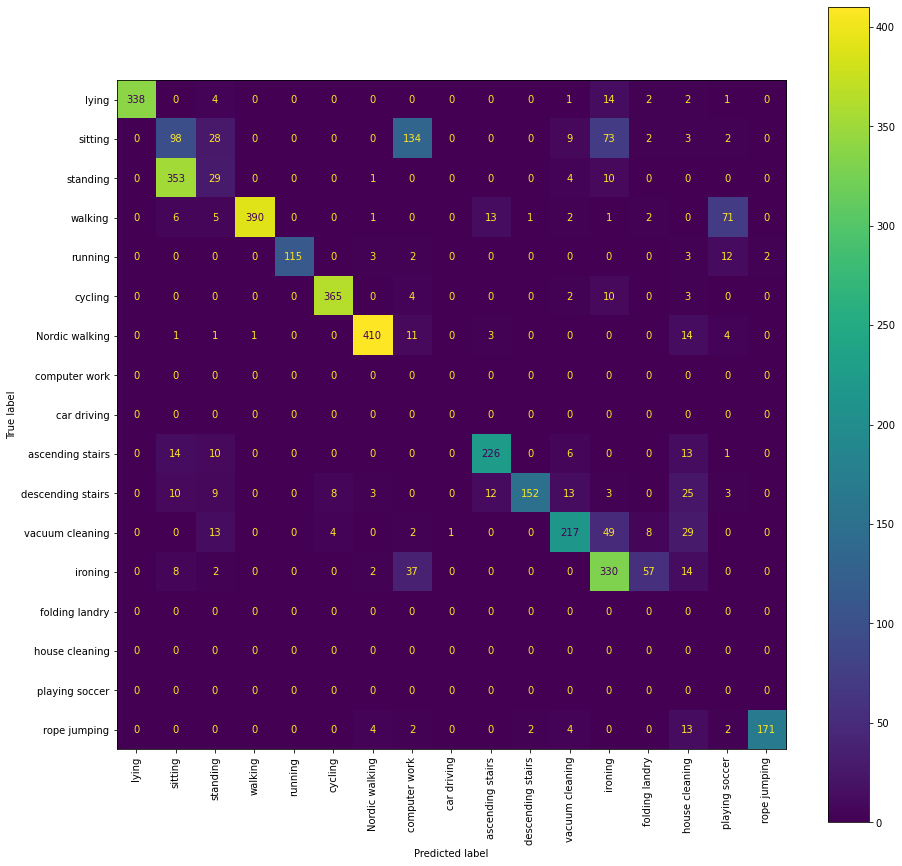

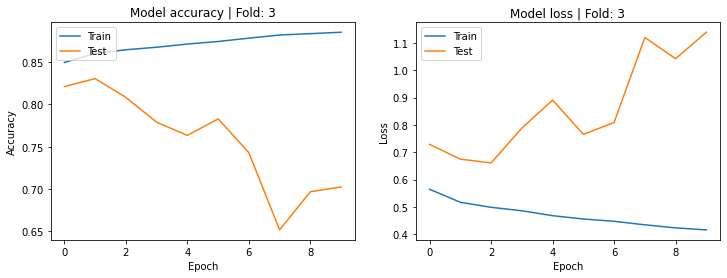

In [106]:
fold_metrics(y_value_last_epoch_fold, folds)

In [107]:
torch.save(model, 'models/improved_combined_model.pt')

In [309]:
class improved_cnn_dataset(Dataset):    
    def __init__(self, label, data, window_size, step, transform=None):
        self.label = label
        self.data = data
        self.win = window_size
        self.step = step
        self.transform = transform
        
    def __len__(self):
        return int(((len(self.data) - self.win) / self.step) + 1)
    
    def __getitem__(self,idx):
        X = np.zeros((18, self.win, 1))
        window = self.data.iloc[(idx * self.step) : (idx * self.step) + self.win, :]
        for i in range(18):
            X[i] = np.array([window.iloc[:, i]]).transpose()
        Y = torch.tensor(window[self.label].mode()[0], dtype=torch.long)
        
        if(self.transform):
            return self.transform(X),Y
        else:
            return X, Y

from torchvision.transforms import transforms
train_transforms = transforms.Compose([transforms.ToTensor()])

In [355]:
train_data, test_data = get_train_test_data_with_stride(1)
    
train_data = train_data.drop(columns=['heart rate (bpm)', 'timestamp(s)'])
train_data['activityID'] = train_data.pop('activityID')
train_data['subject_id'] = train_data.pop('subject_id')

test_data = test_data.drop(columns=['heart rate (bpm)', 'timestamp(s)'])
test_data['activityID'] = test_data.pop('activityID')
test_data['subject_id'] = test_data.pop('subject_id')

In [356]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x = train_data.activityID
le.fit(x)
train_data.activityID = le.transform(train_data.activityID)
test_data.activityID = le.transform(test_data.activityID)

In [357]:
train_data

,IMU hand acceleration 1 16g,IMU hand acceleration 2 16g,IMU hand acceleration 3 16g,IMU hand gyroscope 1,IMU hand gyroscope 2,IMU hand gyroscope 3,IMU chest acceleration 1 16g,IMU chest acceleration 2 16g,IMU chest acceleration 3 16g,IMU chest gyroscope 1,IMU chest gyroscope 2,IMU chest gyroscope 3,IMU ankle acceleration 1 16g,IMU ankle acceleration 2 16g,IMU ankle acceleration 3 16g,IMU ankle gyroscope 1,IMU ankle gyroscope 2,IMU ankle gyroscope 3,activityID,subject_id
0,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,0.124482,9.65003,-1.65181,0.036668,0.016559,-0.052791,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,0,101
1,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,0.200711,9.64980,-1.65043,0.019343,-0.024304,-0.059843,9.69762,-1.884380,-0.020804,0.020882,0.000945,0.006007,0,101
2,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,0.270277,9.72331,-1.88174,-0.001428,0.038466,-0.046464,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,0,101
3,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,0.236737,9.72447,-1.72746,0.017277,-0.048547,-0.074946,9.66370,-1.847140,0.094385,-0.032514,-0.018844,0.026950,0,101
4,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,0.352225,9.72437,-1.68665,0.000275,-0.013352,-0.039315,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,0,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060189,-6.42779,6.84232,2.80728,-0.021124,0.107389,0.043537,1.874740,9.22118,-2.97394,0.124537,0.070576,-0.075640,9.26409,-0.561116,-3.660880,-0.013752,0.011737,-0.011313,16,109
2060190,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,1.798210,9.10846,-2.97496,0.095952,0.061084,-0.058146,9.30900,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,16,109
2060191,-6.41763,6.57977,3.15471,-0.014853,0.079020,0.041868,1.987740,9.14526,-3.01037,0.124518,0.063809,-0.101471,9.30959,-0.069368,-3.470520,-0.010825,-0.025462,-0.057343,16,109
2060192,-6.46049,6.42730,3.03912,0.012556,0.068029,0.050227,2.135430,9.06844,-3.16233,0.113642,0.079775,-0.084217,9.23414,-0.182800,-3.470590,-0.019402,-0.002942,-0.033522,16,109


In [378]:
class improved_cnn_lstm_model(nn.Module):
    def __init__(self,n_features,n_classes,n_hidden=256,n_layer=1):
        super(improved_cnn_lstm_model, self).__init__()
        
        # convolutional layer (sees 1x18x1024 image tensor)
        self.conv1 = nn.Conv2d(1, 16, (1,10), stride=(1,2), padding=0)
        
        # convolutional layer (sees 16x18x82 image tensor)
        self.conv2 = nn.Conv2d(16, 32, (1,8), stride=(1,2), padding=0)
        
        # convolutional layer (sees 64x2x80 tensor)
        self.conv3 = nn.Conv2d(32, 32, (1,3), padding=0)
        
        # output tensor size is 128x1x80
        self.conv4 = nn.Conv2d(32, 32, (1,3), padding=0)
        
        self.pool = nn.MaxPool2d((1,2),(1,2))

        self.lstm  = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layer,
            batch_first=True
        )
        
        
        self.fc1 = nn.Linear(n_hidden,64)
        
        self.fc2 = nn.Linear(64,32)
        
        self.fc3 = nn.Linear(32,n_classes)
        
        self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        
        # 1x18x1024
        x = self.relu(self.conv1(x))
       
        # 1x18x504 
        x = self.pool(x)

        # 1x18x252
        x = self.relu(self.conv2(x))
   
        # 1x18x250 
        x = self.pool(x)

        # 1x18x125 
        x = self.relu(self.conv3(x))
       
        # 1x18x28 
        x = self.pool(x)

        # 1x18x14 
        x = self.relu(self.conv4(x))
   
        # 1x18x12
#         x = self.pool(x)
  
        # 1x18x6
        x = torch.flatten(x,-3,-2)

        # 18x6 
        x = torch.transpose(x, 1, 2)

        # 6x18 
        self.lstm.flatten_parameters()

        _,(hidden,_) = self.lstm(x)
        
        out = hidden[-1]
        
        out = self.dropout(out)
        
        out = self.relu(self.fc1(out))
        
        out = self.dropout(out)
        
        out = self.relu(self.fc2(out))
        
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return out

    
model = improved_cnn_lstm_model(576, 18).to(device)
model

improved_cnn_lstm_model(
  (conv1): Conv2d(1, 16, kernel_size=(1, 10), stride=(1, 2))
  (conv2): Conv2d(16, 32, kernel_size=(1, 8), stride=(1, 2))
  (conv3): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(576, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=18, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

## Run and Evaluate new emproved combined model

In [379]:
folds = {}
y_value_last_epoch_fold = {}
validations = [[103,104]]
WINDOW_SIZE = 1024
STEP = 128
BATCH_SIZE = 32 
LABEL = 'activityID'
learning_rate = 0.0001
epochs = 24
fold_val_acc = 0
best_fold = -1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for fold, validation_list in enumerate(validations):
    print(f'Starting fold: {fold + 1}')

    # split training dataset to training and validation
    train_df,validation_df = split_train_validation(train_data,validation_list)
    train_dataset = improved_cnn_dataset(LABEL, train_df, WINDOW_SIZE, STEP, train_transforms)
    validation_dataset = improved_cnn_dataset(LABEL, validation_df,WINDOW_SIZE, STEP, train_transforms)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
    validation_loader = DataLoader(validation_dataset,batch_size=BATCH_SIZE,shuffle=True)
    
    
    st = time.time()
    history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}  
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}')
        # train epoch
        train_epoch_loss,train_epoch_acc = train_loop(train_loader,model,device,loss_fn,optimizer)
        val_loss,val_acc,y_pred_list,y_true_list  = val_loop(validation_loader,model,device,loss_fn)
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.4f} % AVG Val Acc {:.4f} %".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             train_epoch_loss,
                                                                                                             val_loss,
                                                                                                             train_epoch_acc,
                                                                                                             val_acc))
        history['train_loss'].append(train_epoch_loss.detach().cpu().numpy())
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch == epochs-1):
            y_value_last_epoch_fold[fold] = y_true_list, y_pred_list
        
        if val_acc > fold_val_acc:
            fold_val_acc=val_acc
            best_fold = fold
            torch.save(model.state_dict(), f'model_weights_fold_{fold}.pth')
    
    et=time.time()
    total_fold_time = et-st
    history["time"]=total_fold_time
    folds[fold]=history

Starting fold: 1
Starting epoch 1
loss=2.892, 0 samples / 12949
validatio accuracy = 0.620887895241137, validation loss = 1.624695
Epoch:1/24 AVG Training Loss:2.119 AVG Val Loss:1.625 AVG Training Acc 0.3756 % AVG Val Acc 0.6209 %
Starting epoch 2
loss=1.728, 0 samples / 12949
validatio accuracy = 0.7588629830725008, validation loss = 1.096726
Epoch:2/24 AVG Training Loss:1.094 AVG Val Loss:1.097 AVG Training Acc 0.6930 % AVG Val Acc 0.7589 %
Starting epoch 3
loss=0.694, 0 samples / 12949
validatio accuracy = 0.801980198019802, validation loss = 0.900938
Epoch:3/24 AVG Training Loss:0.721 AVG Val Loss:0.901 AVG Training Acc 0.7988 % AVG Val Acc 0.8020 %
Starting epoch 4
loss=0.625, 0 samples / 12949
validatio accuracy = 0.744490578090067, validation loss = 0.907333
Epoch:4/24 AVG Training Loss:0.524 AVG Val Loss:0.907 AVG Training Acc 0.8558 % AVG Val Acc 0.7445 %
Starting epoch 5
loss=0.506, 0 samples / 12949
validatio accuracy = 0.8013414244650271, validation loss = 0.740147
Epoch:5

In [380]:
for i in range(len(folds)):
    print_fold_info(folds[i],i)

fold metrics of last epoch for fold 1
train loss : 0.070700936
validation loss : 1.1686911789738401
train accuracy : 0.9806934898447757
validation accuracy : 0.7694027467262855
fold time : 14.814363312721252 minutes


In [381]:
avg_train_loss = np.mean([np.mean(folds[i]['train_loss'][len(folds[i]['train_loss'])-1]) for i in range(len(folds))])
avg_valt_loss =  np.mean([np.mean(folds[i]['val_loss'][len(folds[i]['val_loss'])-1]) for i in range(len(folds))])
avg_train_acc = np.mean([np.mean(folds[i]['train_acc'][len(folds[i]['train_acc'])-1]) for i in range(len(folds))])
avg_val_acc = np.mean([np.mean(folds[i]['val_acc'][len(folds[i]['val_acc'])-1]) for i in range(len(folds))])
avg_fold_time = np.mean([folds[i]['time'] for i in range(len(folds))])/60
print('Performance of {} fold cross validation'.format(3))
print("Average Training Loss: {:.4f} \t Average Val Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Val Acc: {:.3f} \t Average Fold time: {:.34f} minutes".format(avg_train_loss,avg_valt_loss,avg_train_acc,avg_val_acc,avg_fold_time))  

Performance of 3 fold cross validation
Average Training Loss: 0.0707 	 Average Val Loss: 1.1687 	 Average Training Acc: 0.981 	 Average Val Acc: 0.769 	 Average Fold time: 14.8143633127212517308635142398998141 minutes


In [382]:
model.load_state_dict(torch.load(f'model_weights_fold_{best_fold}.pth'))
test_dataset = improved_cnn_dataset(LABEL, test_data, WINDOW_SIZE, STEP, train_transforms)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)
test_loss,test_acc , y_pred_list , y_true_list=test_loop(test_loader,model,device,loss_fn)
print("test loss : " + str(test_loss))
print("test accuracy : " + str(test_acc))

accuracy = 0.6103220644128826, test_loss = 1.302298
test loss : 1.302297683658114
test accuracy : 0.6103220644128826



Fold: 1
Accuracy: 0.620
weighted Recall: 0.620
weighted Precision: 0.695
weighted F1-score: 0.583


C:\Users\Tomer\anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



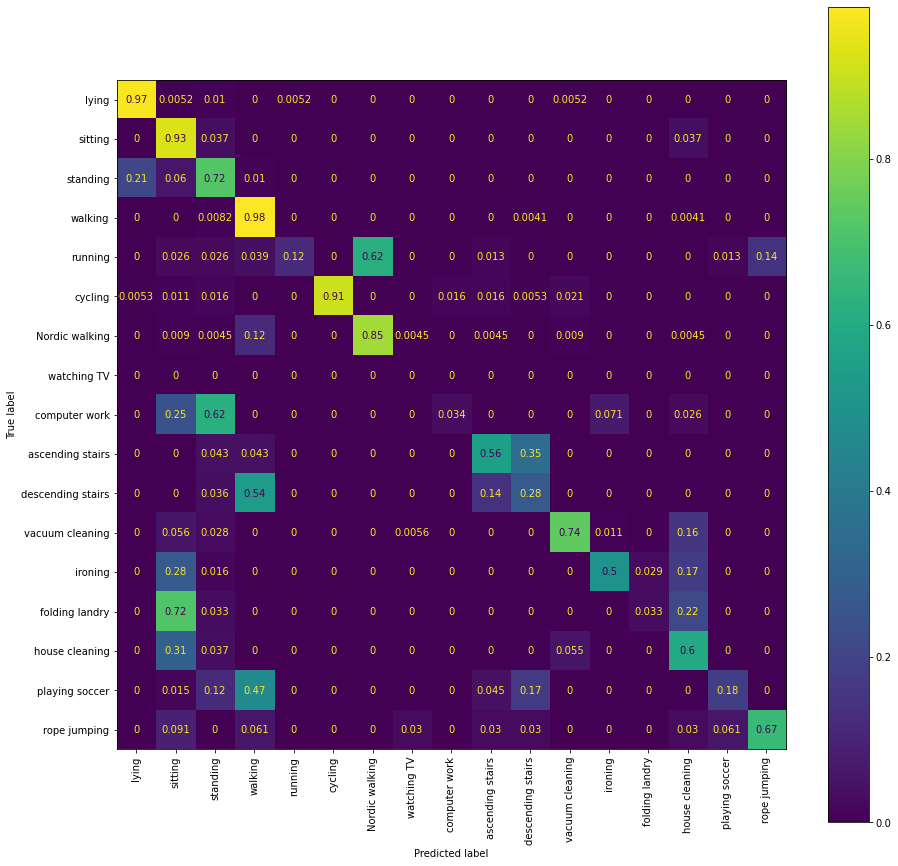

In [366]:
Evaluate(y_true_list,y_pred_list)


Fold: 1
Accuracy: 0.565
weighted Precision: 0.871
weighted F1-score: 0.653


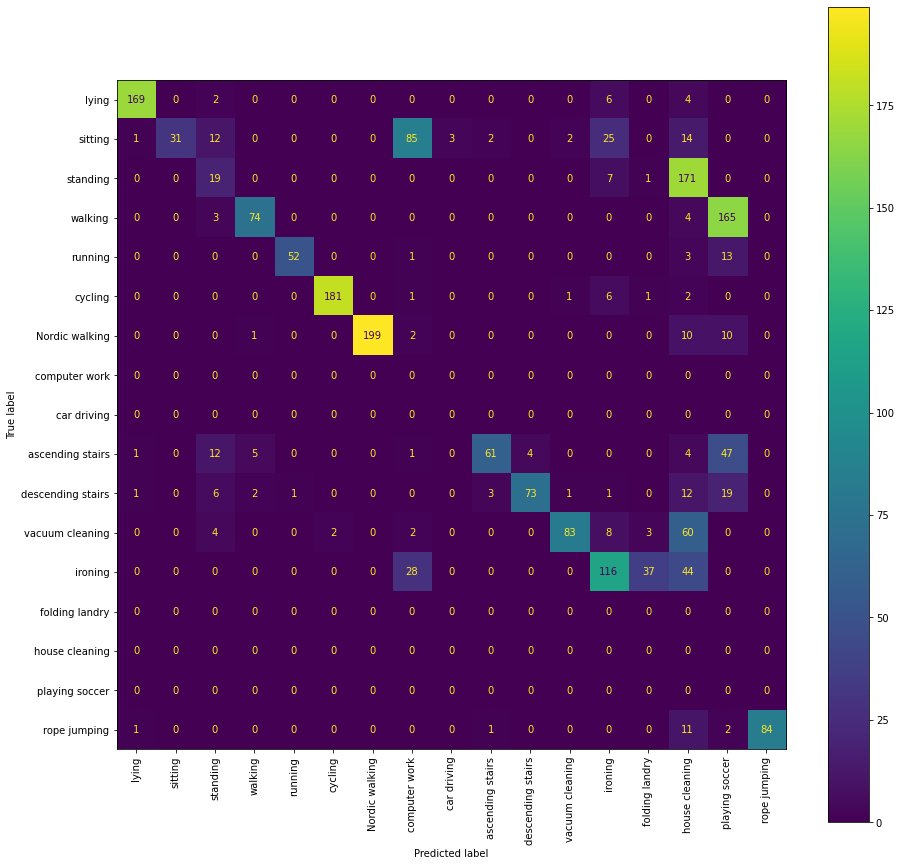

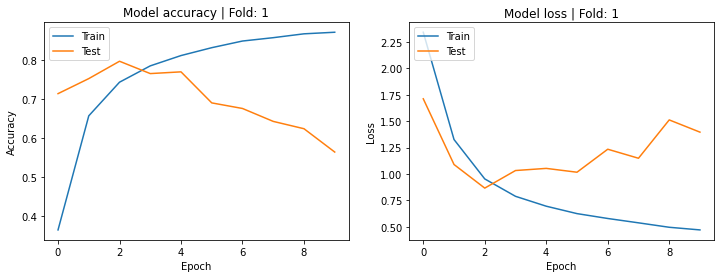

In [223]:
fold_metrics(y_value_last_epoch_fold, folds)

In [224]:
torch.save(model, 'models/improved_combined_model.pt')